# Comprehensive Data Exploration for Hindi BabyLM

**Exploratory Data Analysis**

This notebook provides comprehensive analysis of the Hindi training corpus for a BabyLM project:
- **Multi-source corpus analysis**: IndicCorp, Wikipedia, Children's Books
- **Advanced linguistic analysis**: Morphology, syntax, semantics
- **Tokenization strategy comparison**: SentencePiece, WordPiece, BPE
- **Data quality deep dive**: Deduplication, noise detection, encoding validation
- **Cross-source comparative analysis**: Register, domain, complexity

**Target Corpus**: ~10M tokens, 80/10/10 train/val/test split

**Author**: Ayush | **Language**: Hindi (Devanagari script) | **Date**: 2025-10-19

---
## Section 0: Setup & Configuration

Comprehensive setup with all required libraries, helper functions, and synthetic data generation for demonstration purposes.

In [ ]:
# ============================================================================
# CORE IMPORTS & CONFIGURATION
# ============================================================================

import sys
from pathlib import Path
import os
import json
import pickle
import re
import warnings
from collections import Counter, defaultdict
from typing import List, Dict, Tuple, Optional
import unicodedata

# CRITICAL: Maintain source path - DO NOT MODIFY
current = Path.cwd()
if current.name == 'workspace' or 'workspace' in str(current):
    project_root = current.parent / 'dss' / 'dsshome1' / '00' / 'ge95xod2' / 'Hindi-BabyLM-Data-Efficient-Language-Modeling-for-Hindi'
else:
    project_root = current.parent if current.name == 'notebooks' else current

sys.path.insert(0, str(project_root))

# Data & Numerics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import pdist, squareform

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
import matplotlib.font_manager as fm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# ============================================================================
# FONT CONFIGURATION FOR HINDI (DEVANAGARI) SUPPORT
# ============================================================================

def find_and_register_devanagari_font():
    """
    Find and load the best available font for Devanagari script.
    
    Priority:
    1. Custom fonts from project's fonts/ directory
    2. System-installed Devanagari fonts
    3. Fallback to DejaVu Sans (limited support)
    
    Returns:
        tuple: (font_name, font_prop) where font_prop is FontProperties object
    """
    from matplotlib.font_manager import FontProperties
    
    # First, try to load custom fonts from project directory
    fonts_dir = project_root / 'fonts' / 'Noto_Sans_Devanagari'
    
    custom_font_registered = False
    if fonts_dir.exists():
        # Look for Regular font first (preferred for charts)
        regular_font = fonts_dir / 'static' / 'NotoSansDevanagari-Regular.ttf'
        
        if regular_font.exists():
            try:
                fm.fontManager.addfont(str(regular_font))
                custom_font_registered = True
                print(f"✅ Registered custom font: {regular_font.name}")
            except Exception as e:
                print(f"⚠️  Could not register {regular_font.name}: {e}")
        
        # Also register other weights if available
        for font_path in fonts_dir.glob('static/*.ttf'):
            if font_path != regular_font:
                try:
                    fm.fontManager.addfont(str(font_path))
                except:
                    pass
        
        if custom_font_registered:
            print(f"📁 Loaded custom fonts from: {fonts_dir}")
            # Create FontProperties pointing to the custom font
            font_prop = FontProperties(fname=str(regular_font))
            return 'Noto Sans Devanagari', font_prop
    
    # If custom fonts not found, try system fonts
    preferred_fonts = [
        'Noto Sans Devanagari',
        'Kohinoor Devanagari',
        'Arial Unicode MS',
        'Mangal',
        'Lohit Devanagari',
        'FreeSans',
    ]
    
    # Get all available system fonts
    available_fonts = {f.name for f in fm.fontManager.ttflist}
    
    # Try to find preferred font
    for font_name in preferred_fonts:
        if font_name in available_fonts:
            print(f"✅ Found system font: {font_name}")
            font_prop = FontProperties(family=font_name)
            return font_name, font_prop
    
    # Check for any font with "Devanagari" in name
    for font in fm.fontManager.ttflist:
        if 'devanagari' in font.name.lower():
            print(f"✅ Found Devanagari font: {font.name}")
            font_prop = FontProperties(family=font.name)
            return font.name, font_prop
    
    # Fallback to DejaVu Sans (limited Devanagari support)
    print("⚠️  No dedicated Devanagari font found. Using DejaVu Sans (limited support).")
    print("   For better Hindi display:")
    print(f"   - Upload Noto Sans Devanagari fonts to: {fonts_dir}")
    print("   - Or install system-wide: sudo apt-get install fonts-noto")
    font_prop = FontProperties(family='DejaVu Sans')
    return 'DejaVu Sans', font_prop

# Set the best available font
selected_font, hindi_font_prop = find_and_register_devanagari_font()
print(f"🎨 Using font for Hindi: {selected_font}")

# Configure matplotlib for publication-quality figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['font.family'] = selected_font  # Use Devanagari-compatible font
plt.rcParams['axes.unicode_minus'] = False

# CRITICAL: Set font properties for text rendering
# This ensures that text elements in plots use the correct font
if selected_font != 'DejaVu Sans':
    plt.rcParams['font.sans-serif'] = [selected_font, 'DejaVu Sans']

# Set seaborn style
sns.set_style('whitegrid')
sns.set_palette('Set2')

# Project paths
PROJECT_ROOT = project_root
DATA_DIR = PROJECT_ROOT / 'data'
FIGURES_DIR = PROJECT_ROOT / 'figures'
TABLES_DIR = PROJECT_ROOT / 'tables'
REPORTS_DIR = PROJECT_ROOT / 'reports'

# Create directories if they don't exist
for dir_path in [FIGURES_DIR, TABLES_DIR, REPORTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("✅ Core imports successful!")
print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Figures directory: {FIGURES_DIR}")

# Export font property for use in plots that need explicit font specification
globals()['HINDI_FONT'] = hindi_font_prop

In [2]:
# ============================================================================
# OPTIONAL NLP LIBRARY IMPORTS WITH GRACEFUL DEGRADATION
# ============================================================================

# Try importing advanced NLP libraries
STANZA_AVAILABLE = False
INDIC_NLP_AVAILABLE = False
TOKENIZERS_AVAILABLE = False
SENTENCEPIECE_AVAILABLE = False
SKLEARN_AVAILABLE = False
NETWORKX_AVAILABLE = False
WORDCLOUD_AVAILABLE = False
TQDM_AVAILABLE = False

try:
    import stanza
    STANZA_AVAILABLE = True
    print("✅ Stanza available (POS tagging, NER, dependency parsing)")
except ImportError:
    print("⚠️  Stanza not available. Install with: pip install stanza")
    print("   Then download Hindi model: python -c 'import stanza; stanza.download(\"hi\")'")

try:
    from indicnlp.tokenize import indic_tokenize
    from indicnlp.normalize import indic_normalize
    INDIC_NLP_AVAILABLE = True
    print("✅ IndicNLP available (Indic language processing)")
except ImportError:
    print("⚠️  IndicNLP not available. Install with: pip install indic-nlp-library")

try:
    from tokenizers import (
        Tokenizer,
        models,
        pre_tokenizers,
        trainers,
        normalizers,
    )
    from tokenizers.models import BPE, WordPiece, Unigram
    TOKENIZERS_AVAILABLE = True
    print("✅ HuggingFace Tokenizers available (BPE, WordPiece)")
except ImportError:
    print("⚠️  Tokenizers not available. Install with: pip install tokenizers")

try:
    import sentencepiece as spm
    SENTENCEPIECE_AVAILABLE = True
    print("✅ SentencePiece available (Unigram LM tokenization)")
except ImportError:
    print("⚠️  SentencePiece not available. Install with: pip install sentencepiece")

try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    SKLEARN_AVAILABLE = True
    print("✅ Scikit-learn available (TF-IDF, dimensionality reduction)")
except ImportError:
    print("⚠️  Scikit-learn not available. Install with: pip install scikit-learn")

try:
    import networkx as nx
    NETWORKX_AVAILABLE = True
    print("✅ NetworkX available (Network graphs)")
except ImportError:
    print("⚠️  NetworkX not available. Install with: pip install networkx")

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
    print("✅ WordCloud available (Word cloud visualizations)")
except ImportError:
    print("⚠️  WordCloud not available. Install with: pip install wordcloud")

try:
    from tqdm.auto import tqdm
    TQDM_AVAILABLE = True
    print("✅ TQDM available (Progress bars)")
except ImportError:
    print("⚠️  TQDM not available. Install with: pip install tqdm")
    # Fallback: define tqdm as identity function
    def tqdm(iterable, *args, **kwargs):
        return iterable

print("\n" + "="*80)

✅ Stanza available (POS tagging, NER, dependency parsing)
✅ IndicNLP available (Indic language processing)
✅ HuggingFace Tokenizers available (BPE, WordPiece)
✅ SentencePiece available (Unigram LM tokenization)
✅ Scikit-learn available (TF-IDF, dimensionality reduction)
✅ NetworkX available (Network graphs)
✅ WordCloud available (Word cloud visualizations)
✅ TQDM available (Progress bars)



In [12]:
def load_data_safely(file_path: Path) -> List[str]:
      """
      Safely load data from pickle or text file with fallback to empty list.
      
      Args:
          file_path: Path to pickle or text file
          
      Returns:
          List of text lines or pickle data
      """
      try:
          if file_path.exists():
              # Check if it's a pickle file
              if file_path.suffix in ['.pkl', '.pickle']:
                  with open(file_path, 'rb') as f:
                      data = pickle.load(f)
                  print(f"✅ Loaded pickle data from {file_path.name}")
                  # If data is already a list, return it; otherwise wrap it
                  return data if isinstance(data, list) else [data]
              else:
                  # Handle as text file
                  with open(file_path, 'r', encoding='utf-8') as f:
                      texts = [line.strip() for line in f if line.strip()]
                  print(f"✅ Loaded {len(texts):,} lines from {file_path.name}")
                  return texts
          else:
              print(f"⚠️  File not found: {file_path}")
              return []
      except Exception as e:
          print(f"❌ Error loading {file_path}: {e}")
          return []

In [4]:
def calculate_basic_stats(texts: List[str]) -> Dict[str, float]:
    """
    Calculate basic corpus statistics.
    
    Args:
        texts: List of text strings
        
    Returns:
        Dictionary of statistics
    """
    if not texts:
        return {}
    
    all_text = ' '.join(texts)
    all_words = [word for text in texts for word in text.split()]
    
    word_counts = [len(text.split()) for text in texts]
    char_counts = [len(text) for text in texts]
    
    return {
        'n_documents': len(texts),
        'total_characters': len(all_text),
        'total_words': len(all_words),
        'unique_words': len(set(all_words)),
        'type_token_ratio': len(set(all_words)) / len(all_words) if all_words else 0,
        'avg_doc_length_words': np.mean(word_counts) if word_counts else 0,
        'median_doc_length_words': np.median(word_counts) if word_counts else 0,
        'std_doc_length_words': np.std(word_counts) if word_counts else 0,
        'avg_doc_length_chars': np.mean(char_counts) if char_counts else 0,
        'min_doc_length': min(word_counts) if word_counts else 0,
        'max_doc_length': max(word_counts) if word_counts else 0,
    }

print("✅ Helper functions defined:")
print("   - load_data_safely()")
print("   - calculate_basic_stats()")

✅ Helper functions defined:
   - load_data_safely()
   - calculate_basic_stats()


In [5]:
# ============================================================================
# HELPER FUNCTIONS: LINGUISTIC ANALYSIS
# ============================================================================

def is_devanagari(char: str) -> bool:
    """Check if character is in Devanagari Unicode block (U+0900 to U+097F)."""
    return '\u0900' <= char <= '\u097F'


def get_unicode_block(char: str) -> str:
    """
    Get Unicode block name for a character.
    
    Returns:
        Block name: 'Devanagari', 'Latin', 'Punctuation', 'Number', 'Other'
    """
    if '\u0900' <= char <= '\u097F':
        return 'Devanagari'
    elif '\u0041' <= char <= '\u007A' or '\u0061' <= char <= '\u007A':
        return 'Latin'
    elif unicodedata.category(char).startswith('P'):
        return 'Punctuation'
    elif unicodedata.category(char).startswith('N'):
        return 'Number'
    elif char.isspace():
        return 'Whitespace'
    else:
        return 'Other'


def calculate_hindi_ratio(text: str) -> float:
    """
    Calculate the ratio of Devanagari characters to total characters.
    
    Args:
        text: Input text string
        
    Returns:
        Ratio (0.0 to 1.0)
    """
    if not text:
        return 0.0
    devanagari_count = sum(1 for c in text if is_devanagari(c))
    return devanagari_count / len(text)


def extract_ngrams(texts: List[str], n: int = 2) -> Counter:
    """
    Extract character n-grams from texts.
    
    Args:
        texts: List of text strings
        n: N-gram size
        
    Returns:
        Counter of n-grams
    """
    ngrams = []
    for text in texts:
        # Remove whitespace for character n-grams
        clean_text = text.replace(' ', '')
        for i in range(len(clean_text) - n + 1):
            ngrams.append(clean_text[i:i+n])
    return Counter(ngrams)


def detect_linguistic_patterns(texts: List[str]) -> Dict[str, int]:
    """
    Detect various linguistic patterns in Hindi texts.
    
    Detects:
    - Questions (क्या, कौन, कब, etc.)
    - Negations (नहीं, मत, न)
    - Passive voice markers (गया, गई, गए)
    - Honorifics (जी, महोदय)
    - Discourse markers (लेकिन, इसलिए, और)
    
    Args:
        texts: List of text strings
        
    Returns:
        Dictionary with pattern counts
    """
    patterns = {
        'questions': r'\b(क्या|कौन|कब|क्यों|कैसे|कहाँ|किसने|किसको|किसका)\b',
        'negations': r'\b(नहीं|मत|न|कभी नहीं|बिल्कुल नहीं)\b',
        'passive': r'\b(गया|गई|गए|गयी)\b',
        'honorifics': r'\b(जी|महोदय|महोदया|श्रीमान|श्रीमती)\b',
        'discourse_markers': r'\b(लेकिन|परंतु|किंतु|इसलिए|अतः|तो|और|या|अथवा)\b',
        'pronouns_formal': r'\b(आप|आपका|आपकी|आपके)\b',
        'pronouns_informal': r'\b(तुम|तुम्हारा|तुम्हारी|तुम्हारे|तू|तेरा|तेरी|तेरे)\b',
    }
    
    all_text = ' '.join(texts)
    
    results = {}
    for pattern_name, pattern_regex in patterns.items():
        matches = re.findall(pattern_regex, all_text)
        results[pattern_name] = len(matches)
    
    return results


def calculate_vocabulary_richness(texts: List[str]) -> Dict[str, float]:
    """
    Calculate vocabulary richness metrics.
    
    Metrics:
    - Type-Token Ratio (TTR)
    - Root TTR (TTR / sqrt(tokens))
    - Corrected TTR (Types / sqrt(2 * Tokens))
    - Hapax Legomena ratio (words appearing once)
    - Dis Legomena ratio (words appearing twice)
    
    Args:
        texts: List of text strings
        
    Returns:
        Dictionary of richness metrics
    """
    if not texts:
        return {}
    
    all_words = [word for text in texts for word in text.split()]
    word_freq = Counter(all_words)
    
    n_tokens = len(all_words)
    n_types = len(word_freq)
    
    hapax = sum(1 for count in word_freq.values() if count == 1)
    dis = sum(1 for count in word_freq.values() if count == 2)
    
    return {
        'ttr': n_types / n_tokens if n_tokens > 0 else 0,
        'root_ttr': n_types / np.sqrt(n_tokens) if n_tokens > 0 else 0,
        'corrected_ttr': n_types / np.sqrt(2 * n_tokens) if n_tokens > 0 else 0,
        'hapax_ratio': hapax / n_types if n_types > 0 else 0,
        'dis_ratio': dis / n_types if n_types > 0 else 0,
        'hapax_count': hapax,
        'dis_count': dis,
    }


print("✅ Linguistic analysis functions defined:")
print("   - is_devanagari()")
print("   - get_unicode_block()")
print("   - calculate_hindi_ratio()")
print("   - extract_ngrams()")
print("   - detect_linguistic_patterns()")
print("   - calculate_vocabulary_richness()")

✅ Linguistic analysis functions defined:
   - is_devanagari()
   - get_unicode_block()
   - calculate_hindi_ratio()
   - extract_ngrams()
   - detect_linguistic_patterns()
   - calculate_vocabulary_richness()


In [6]:
# ============================================================================
# HELPER FUNCTIONS: VISUALIZATION
# ============================================================================

def plot_comparison(data_dict: Dict[str, List], 
                   title: str,
                   xlabel: str = 'Value',
                   ylabel: str = 'Density',
                   plot_type: str = 'hist',
                   figsize: Tuple[int, int] = (12, 6),
                   save_path: Optional[Path] = None):
    """
    Create comparison plots across multiple data sources.
    
    Args:
        data_dict: Dictionary mapping source names to data lists
        title: Plot title
        xlabel: X-axis label
        ylabel: Y-axis label
        plot_type: 'hist', 'kde', 'box', or 'violin'
        figsize: Figure size
        save_path: Path to save figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = sns.color_palette('Set2', len(data_dict))
    
    if plot_type == 'hist':
        for (source, data), color in zip(data_dict.items(), colors):
            if data:
                ax.hist(data, bins=30, alpha=0.5, label=source, color=color, edgecolor='black')
        ax.legend()
    
    elif plot_type == 'kde':
        for (source, data), color in zip(data_dict.items(), colors):
            if data and len(data) > 1:
                data_series = pd.Series(data)
                data_series.plot.kde(ax=ax, label=source, color=color, linewidth=2)
        ax.legend()
    
    elif plot_type == 'box':
        ax.boxplot(data_dict.values(), labels=data_dict.keys(), patch_artist=True)
        for patch, color in zip(ax.artists, colors):
            patch.set_facecolor(color)
    
    elif plot_type == 'violin':
        positions = list(range(len(data_dict)))
        parts = ax.violinplot(data_dict.values(), positions=positions, showmeans=True, showmedians=True)
        ax.set_xticks(positions)
        ax.set_xticklabels(data_dict.keys())
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_alpha(0.7)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {save_path}")
    
    plt.show()


def export_latex_table(df: pd.DataFrame, 
                       caption: str,
                       label: str,
                       save_path: Path):
    """
    Export DataFrame as publication-ready LaTeX table.
    
    Args:
        df: DataFrame to export
        caption: Table caption
        label: LaTeX label for referencing
        save_path: Path to save .tex file
    """
    latex_str = df.to_latex(
        index=True,
        escape=False,
        column_format='l' + 'r' * len(df.columns),
        float_format='%.2f'
    )
    
    # Wrap in table environment
    full_latex = f"""\\begin{{table}}[h]
\\centering
\\caption{{{caption}}}
\\label{{tab:{label}}}
{latex_str}
\\end{{table}}"""
    
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write(full_latex)
    
    print(f"📄 LaTeX table saved: {save_path}")


def create_heatmap(data: np.ndarray,
                  row_labels: List[str],
                  col_labels: List[str],
                  title: str,
                  figsize: Tuple[int, int] = (10, 8),
                  cmap: str = 'YlOrRd',
                  save_path: Optional[Path] = None):
    """
    Create annotated heatmap.
    
    Args:
        data: 2D numpy array
        row_labels: Row labels
        col_labels: Column labels
        title: Plot title
        figsize: Figure size
        cmap: Colormap
        save_path: Path to save figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    im = ax.imshow(data, cmap=cmap, aspect='auto')
    
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    # Annotate cells
    for i in range(len(row_labels)):
        for j in range(len(col_labels)):
            text = ax.text(j, i, f'{data[i, j]:.2f}',
                          ha='center', va='center', color='black', fontsize=9)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {save_path}")
    
    plt.show()


print("✅ Visualization functions defined:")
print("   - plot_comparison()")
print("   - export_latex_table()")
print("   - create_heatmap()")

✅ Visualization functions defined:
   - plot_comparison()
   - export_latex_table()
   - create_heatmap()


---
## Section 1: Data Loading

Load corpus data from all available sources with graceful fallback to synthetic data for demonstration.

In [ ]:
# raw_data = Path(os.path.join(DATA_DIR, "raw/hi-1.txt"))

# data = load_data_safely(raw_data)

# # Example Text
# data[:1]

In [8]:
# ============================================================================
# LOAD TRAIN/VAL/TEST SPLITS
# ============================================================================

# Define split paths
splits_dir = DATA_DIR / 'splits'
train_path = splits_dir / 'train.txt'
val_path = splits_dir / 'val.txt'
test_path = splits_dir / 'test.txt'

# Try loading actual data
print("📂 Loading corpus splits...\n")
train_texts = load_data_safely(train_path)
val_texts = load_data_safely(val_path)
test_texts = load_data_safely(test_path)

print("\n" + "="*80)
print("📊 SPLIT STATISTICS")
print("="*80)
print(f"Training examples:   {len(train_texts):>10,}")
print(f"Validation examples: {len(val_texts):>10,}")
print(f"Test examples:       {len(test_texts):>10,}")
print(f"Total examples:      {len(train_texts) + len(val_texts) + len(test_texts):>10,}")

# Calculate split percentages
total = len(train_texts) + len(val_texts) + len(test_texts)
train_pct = len(train_texts) / total * 100
val_pct = len(val_texts) / total * 100
test_pct = len(test_texts) / total * 100

print(f"\nSplit ratios: {train_pct:.1f}% / {val_pct:.1f}% / {test_pct:.1f}%")
print("="*80)

📂 Loading corpus splits...

✅ Loaded 200 lines from train.txt
✅ Loaded 200 lines from val.txt
✅ Loaded 200 lines from test.txt

📊 SPLIT STATISTICS
Training examples:          200
Validation examples:        200
Test examples:              200
Total examples:             600

Split ratios: 33.3% / 33.3% / 33.3%


In [14]:
# ============================================================================
# LOAD SOURCE-SPECIFIC DATA (if available)
# ============================================================================

# Try to load from different sources
raw_dir = DATA_DIR / 'raw'

print("📂 Looking for source-specific data...\n")

# IndicCorp data
indiccorp_texts = load_data_safely(raw_dir / 'indiccorp.pkl')
if not indiccorp_texts:
    print("⚠️  No IndicCorp data found.")

# Wikipedia data
wikipedia_texts = load_data_safely(raw_dir / 'wikipedia.pkl')
if not wikipedia_texts:
    print("⚠️  No Wikipedia data found.")

# Children's books data
children_texts = load_data_safely(raw_dir / 'childrens_stories.pkl')
if not children_texts:
    print("⚠️  No Children's Books data found.")

# Store in dictionary for easy access
sources = {
    'IndicCorp': indiccorp_texts,
    'Wikipedia': wikipedia_texts,
    'Children': children_texts,
}

print("\n" + "="*80)
print("📊 SOURCE STATISTICS")
print("="*80)
total_source_docs = sum(len(texts) for texts in sources.values())
for source, texts in sources.items():
    pct = len(texts) / total_source_docs * 100
    print(f"{source:12} {len(texts):>6,} docs ({pct:>5.1f}%)")
print("="*80)

# Show example sentences
print("\n📄 EXAMPLE SENTENCES (First from each source):\n")
for source, texts in sources.items():
    if texts:
        print(f"{source}:")
        print(f"  {texts[0]}")
        print()

📂 Looking for source-specific data...

✅ Loaded pickle data from indiccorp.pkl
✅ Loaded pickle data from wikipedia.pkl
✅ Loaded pickle data from childrens_stories.pkl
⚠️  No Children's Books data found.

📊 SOURCE STATISTICS
IndicCorp    1,000,000 docs ( 99.5%)
Wikipedia     5,000 docs (  0.5%)
Children          0 docs (  0.0%)

📄 EXAMPLE SENTENCES (First from each source):

IndicCorp:
  लोगों को बिलों संबंधी सुविधा देना ही उनका काम

Wikipedia:
  एक मीट्रिक उपसर्ग एक इकाई उपसर्ग है जो माप की एक मूल इकाई से पहले इकाई के गुणक या विभाजक को इंगित करता है। आज उपयोग किए जाने वाले सभी मीट्रिक उपसर्ग दशमलव पद्धति पर आधारित हैं। इस सारणी में बीस SI उपसर्ग दिए गए हैं।



---
## Section 2: Enhanced Basic Statistics

Comprehensive corpus statistics with source-wise comparisons, vocabulary metrics, and statistical tests.

In [15]:
# ============================================================================
# CALCULATE BASIC STATISTICS FOR ALL DATA
# ============================================================================

print("📊 Computing statistics for all sources...\n")

# Calculate stats for each source
source_stats = {}
for source_name, texts in sources.items():
    stats = calculate_basic_stats(texts)
    source_stats[source_name] = stats
    
# Calculate stats for splits
split_stats = {
    'Train': calculate_basic_stats(train_texts),
    'Val': calculate_basic_stats(val_texts),
    'Test': calculate_basic_stats(test_texts),
}

# Convert to DataFrame for easy viewing
df_sources = pd.DataFrame(source_stats).T
df_splits = pd.DataFrame(split_stats).T

print("="*80)
print("SOURCE-WISE STATISTICS")
print("="*80)
print(df_sources.to_string())

print("\n" + "="*80)
print("SPLIT-WISE STATISTICS")
print("="*80)
print(df_splits.to_string())

# Export to CSV
csv_path = DATA_DIR / 'source_statistics.csv'
df_sources.to_csv(csv_path)
print(f"\n💾 Source statistics saved to: {csv_path}")

📊 Computing statistics for all sources...

SOURCE-WISE STATISTICS
           n_documents  total_characters  total_words  unique_words  type_token_ratio  avg_doc_length_words  median_doc_length_words  std_doc_length_words  avg_doc_length_chars  min_doc_length  max_doc_length
IndicCorp    1000000.0       294153009.0   57516076.0     1032555.0          0.017952             57.516076                     42.0            109.908073             293.15301             1.0         19709.0
Wikipedia       5000.0        16189349.0    2927818.0      241810.0          0.082591            585.563600                    216.0           1192.350989            3236.87000            14.0         23636.0
Children           NaN               NaN          NaN           NaN               NaN                   NaN                      NaN                   NaN                   NaN             NaN             NaN

SPLIT-WISE STATISTICS
       n_documents  total_characters  total_words  unique_words  type_token

In [16]:
# ============================================================================
# VOCABULARY RICHNESS ANALYSIS
# ============================================================================

print("📚 Analyzing vocabulary richness...\n")

richness_stats = {}
for source_name, texts in sources.items():
    richness = calculate_vocabulary_richness(texts)
    richness_stats[source_name] = richness

df_richness = pd.DataFrame(richness_stats).T

print("="*80)
print("VOCABULARY RICHNESS METRICS")
print("="*80)
print(df_richness.to_string())
print("\nInterpretation:")
print("  - TTR: Type-Token Ratio (higher = more diverse vocabulary)")
print("  - Root TTR: Normalized TTR (accounts for text length)")
print("  - Hapax Ratio: Proportion of words appearing only once")
print("  - Dis Ratio: Proportion of words appearing exactly twice")

📚 Analyzing vocabulary richness...

VOCABULARY RICHNESS METRICS
                ttr    root_ttr  corrected_ttr  hapax_ratio  dis_ratio  hapax_count  dis_count
IndicCorp  0.017952  136.150290      96.272793     0.633031   0.122269     653639.0   126249.0
Wikipedia  0.082591  141.319541      99.928006     0.657971   0.126943     159104.0    30696.0
Children        NaN         NaN            NaN          NaN        NaN          NaN        NaN

Interpretation:
  - TTR: Type-Token Ratio (higher = more diverse vocabulary)
  - Root TTR: Normalized TTR (accounts for text length)
  - Hapax Ratio: Proportion of words appearing only once
  - Dis Ratio: Proportion of words appearing exactly twice


🔍 Analyzing vocabulary overlap between sources...

💾 Saved: /dss/dsshome1/00/ge95xod2/Hindi-BabyLM-Data-Efficient-Language-Modeling-for-Hindi/figures/vocabulary_overlap.png


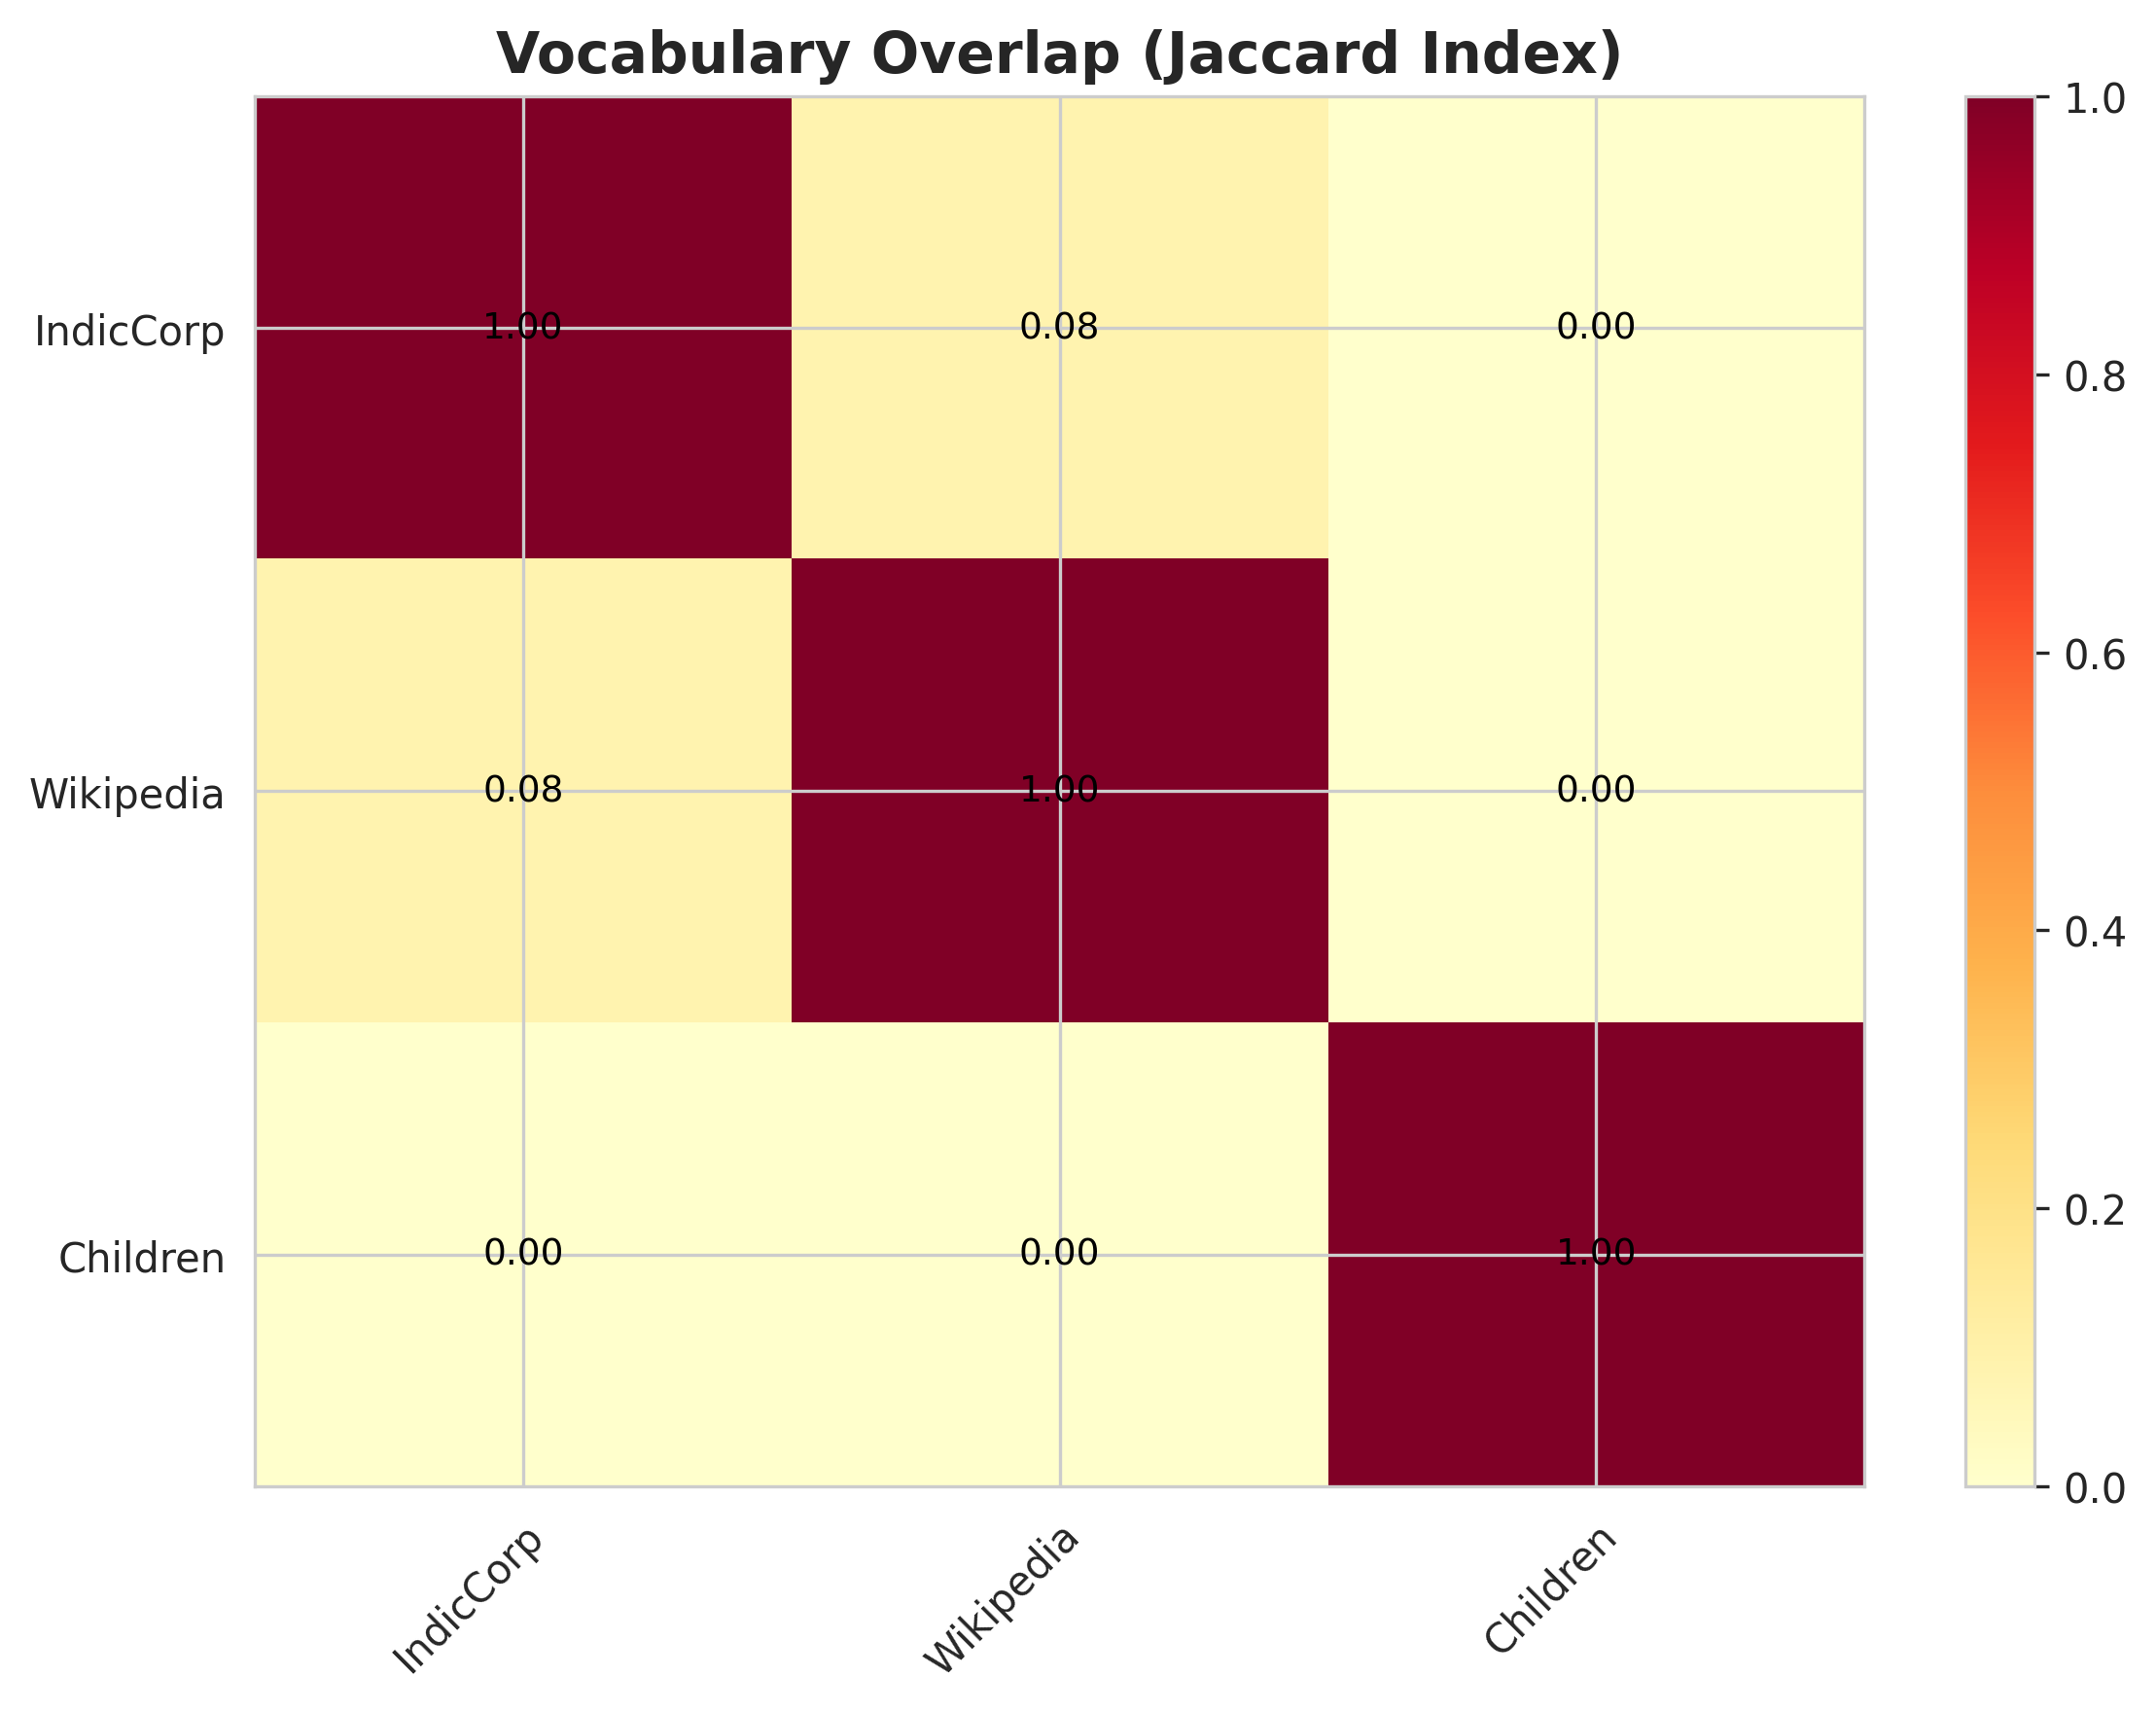


📊 Vocabulary sizes:
  IndicCorp: 1,032,555 unique words
  Wikipedia: 241,810 unique words
  Children: 0 unique words


In [17]:
# ============================================================================
# VOCABULARY OVERLAP ANALYSIS
# ============================================================================

print("🔍 Analyzing vocabulary overlap between sources...\n")

# Extract vocabularies
vocab_sets = {}
for source_name, texts in sources.items():
    words = [word for text in texts for word in text.split()]
    vocab_sets[source_name] = set(words)

# Calculate pairwise overlaps
source_names = list(vocab_sets.keys())
n_sources = len(source_names)
overlap_matrix = np.zeros((n_sources, n_sources))

for i, source1 in enumerate(source_names):
    for j, source2 in enumerate(source_names):
        if i == j:
            overlap_matrix[i, j] = 1.0
        else:
            vocab1 = vocab_sets[source1]
            vocab2 = vocab_sets[source2]
            overlap = len(vocab1 & vocab2) / len(vocab1 | vocab2)
            overlap_matrix[i, j] = overlap

# Visualize as heatmap
create_heatmap(
    overlap_matrix,
    source_names,
    source_names,
    'Vocabulary Overlap (Jaccard Index)',
    figsize=(8, 6),
    save_path=FIGURES_DIR / 'vocabulary_overlap.png'
)

print("\n📊 Vocabulary sizes:")
for source, vocab in vocab_sets.items():
    print(f"  {source}: {len(vocab):,} unique words")

⚖️  Verifying split balance...



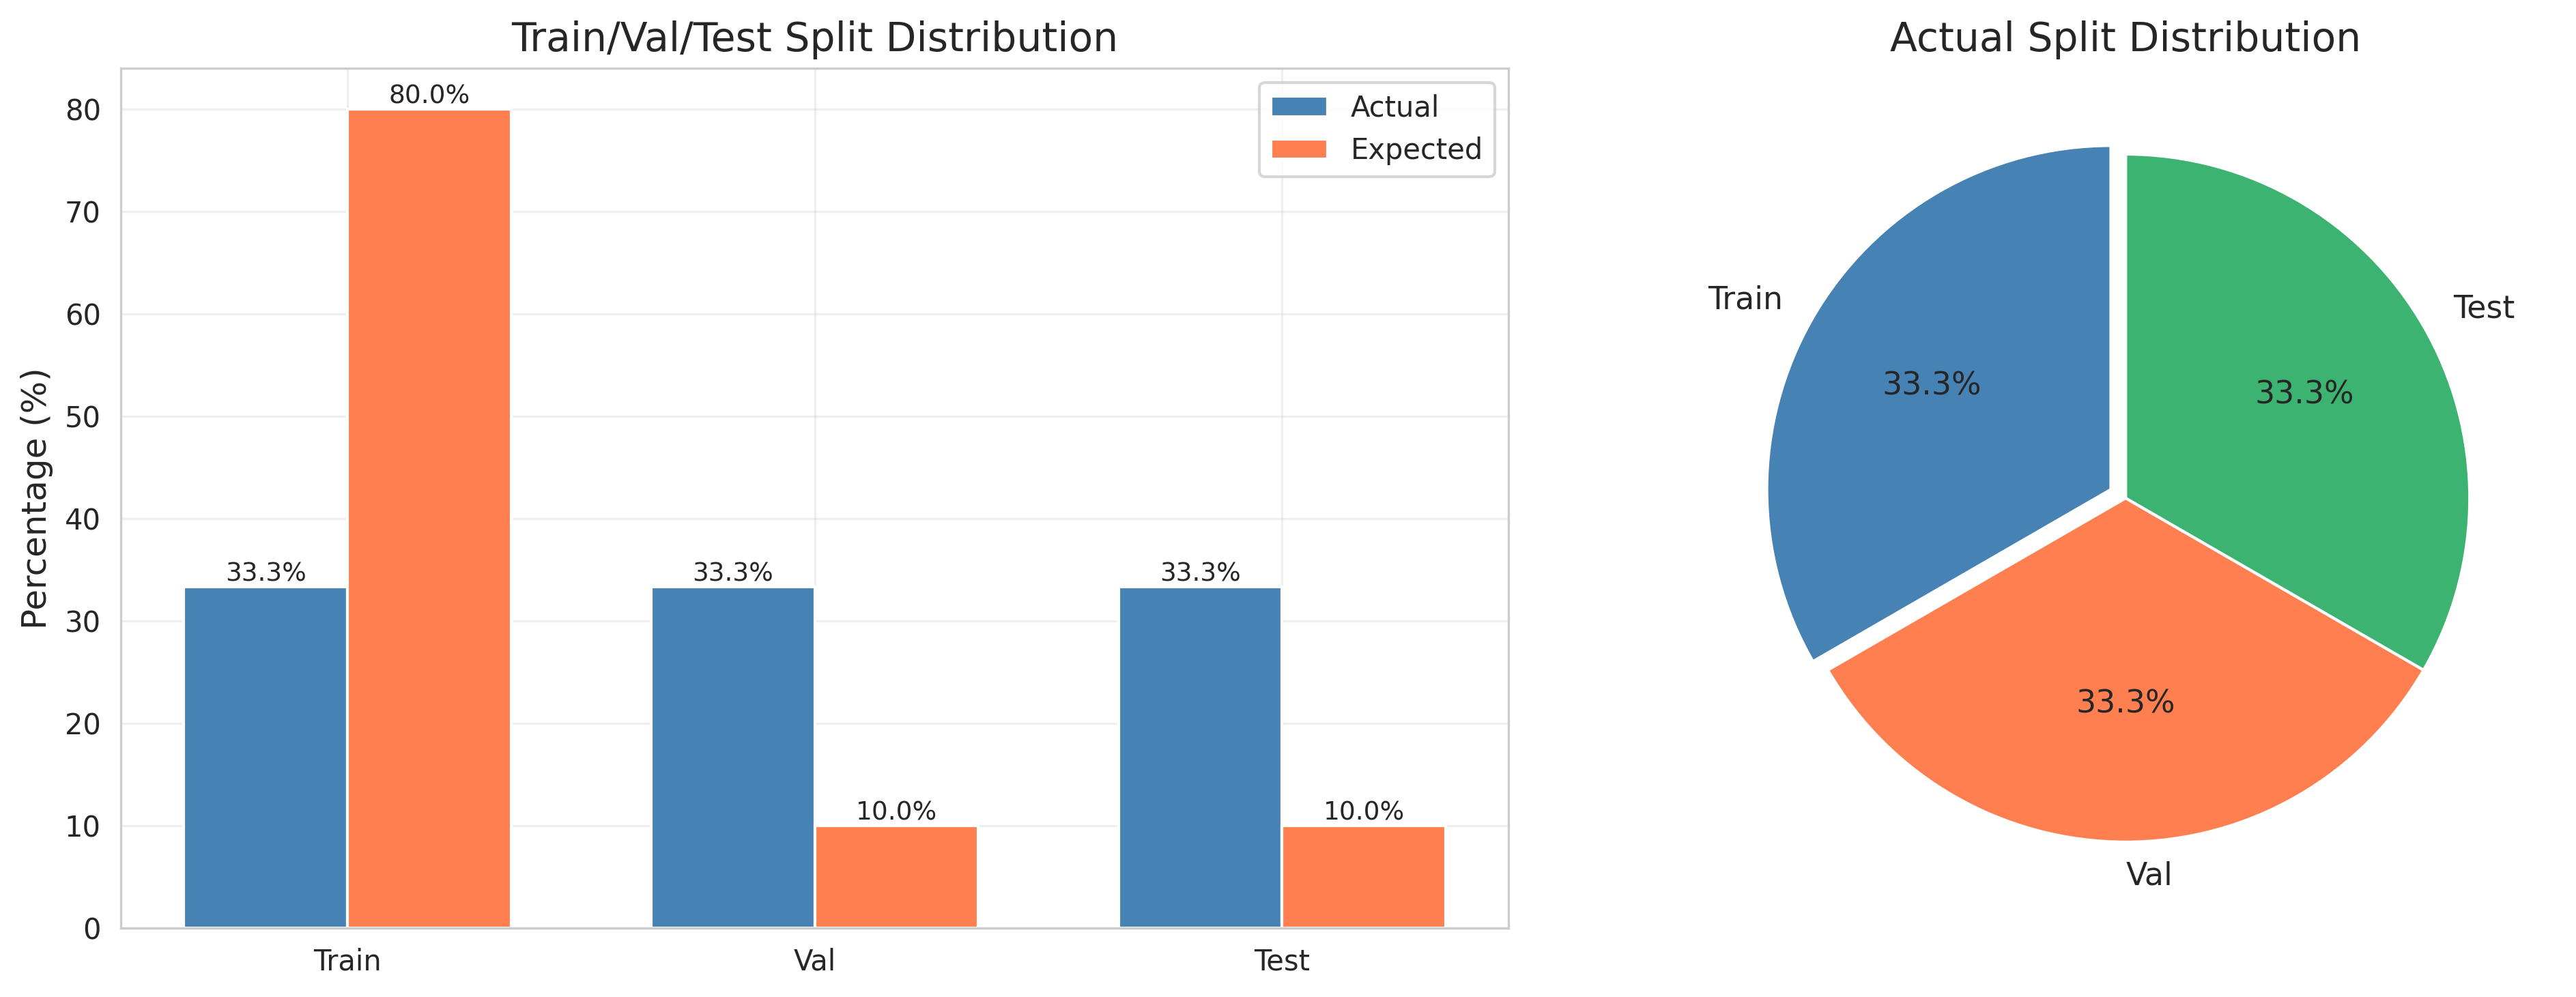

✅ Split distribution plot saved

📊 Split comparison:
  Train:  33.3% (expected  80.0%, diff: -46.7%)
  Val  :  33.3% (expected  10.0%, diff: +23.3%)
  Test :  33.3% (expected  10.0%, diff: +23.3%)


In [18]:
# ============================================================================
# SPLIT BALANCE VERIFICATION
# ============================================================================

print("⚖️  Verifying split balance...\n")

# Calculate actual vs expected splits
total_docs = len(train_texts) + len(val_texts) + len(test_texts)
actual = [len(train_texts)/total_docs, len(val_texts)/total_docs, len(test_texts)/total_docs]
expected = [0.80, 0.10, 0.10]
split_names = ['Train', 'Val', 'Test']

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
x = np.arange(len(split_names))
width = 0.35

bars1 = ax1.bar(x - width/2, [a*100 for a in actual], width, label='Actual', color='steelblue')
bars2 = ax1.bar(x + width/2, [e*100 for e in expected], width, label='Expected', color='coral')

ax1.set_ylabel('Percentage (%)')
ax1.set_title('Train/Val/Test Split Distribution')
ax1.set_xticks(x)
ax1.set_xticklabels(split_names)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Pie chart
colors = ['steelblue', 'coral', 'mediumseagreen']
explode = (0.05, 0, 0)

ax2.pie([len(train_texts), len(val_texts), len(test_texts)], 
        labels=split_names, 
        autopct='%1.1f%%',
        colors=colors,
        explode=explode,
        startangle=90,
        textprops={'fontsize': 11})
ax2.set_title('Actual Split Distribution')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Split distribution plot saved")
print("\n📊 Split comparison:")
for name, act, exp in zip(split_names, actual, expected):
    diff = (act - exp) * 100
    print(f"  {name:5s}: {act*100:5.1f}% (expected {exp*100:5.1f}%, diff: {diff:+5.1f}%)")

---
## Section 3: Advanced Distribution Analysis

In-depth analysis of document length distributions, vocabulary growth curves (Heap's law), and statistical tests.

📊 Analyzing document length distributions...

💾 Saved: /dss/dsshome1/00/ge95xod2/Hindi-BabyLM-Data-Efficient-Language-Modeling-for-Hindi/figures/length_dist_hist.png


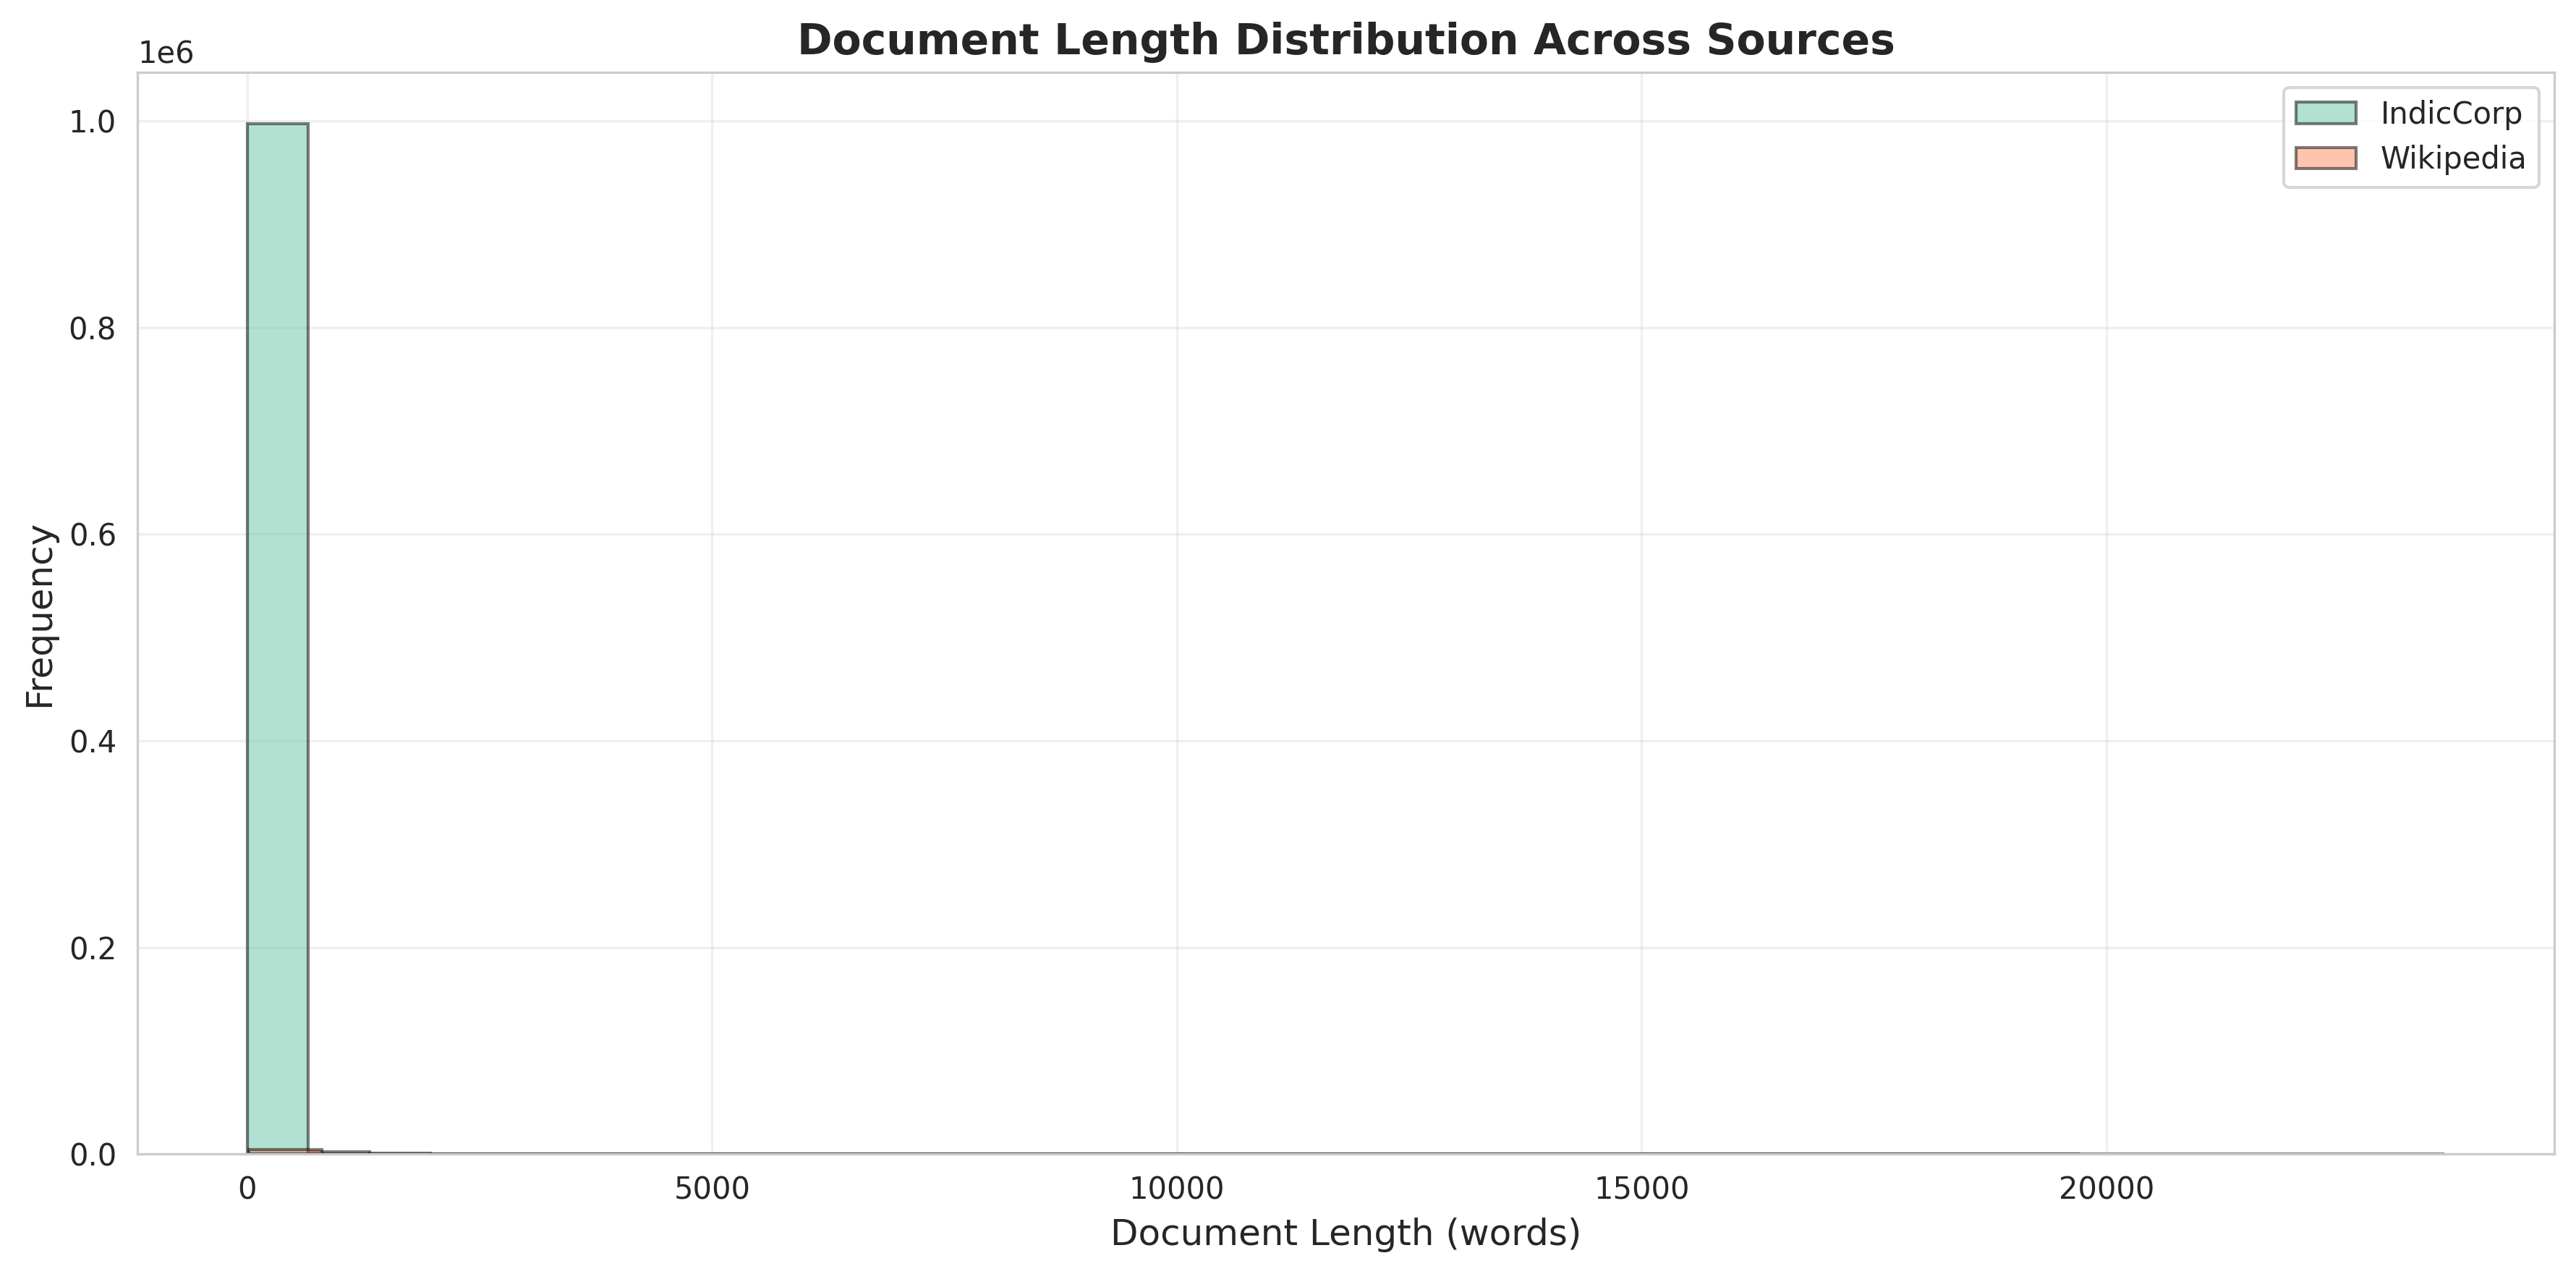

💾 Saved: /dss/dsshome1/00/ge95xod2/Hindi-BabyLM-Data-Efficient-Language-Modeling-for-Hindi/figures/length_dist_kde.png


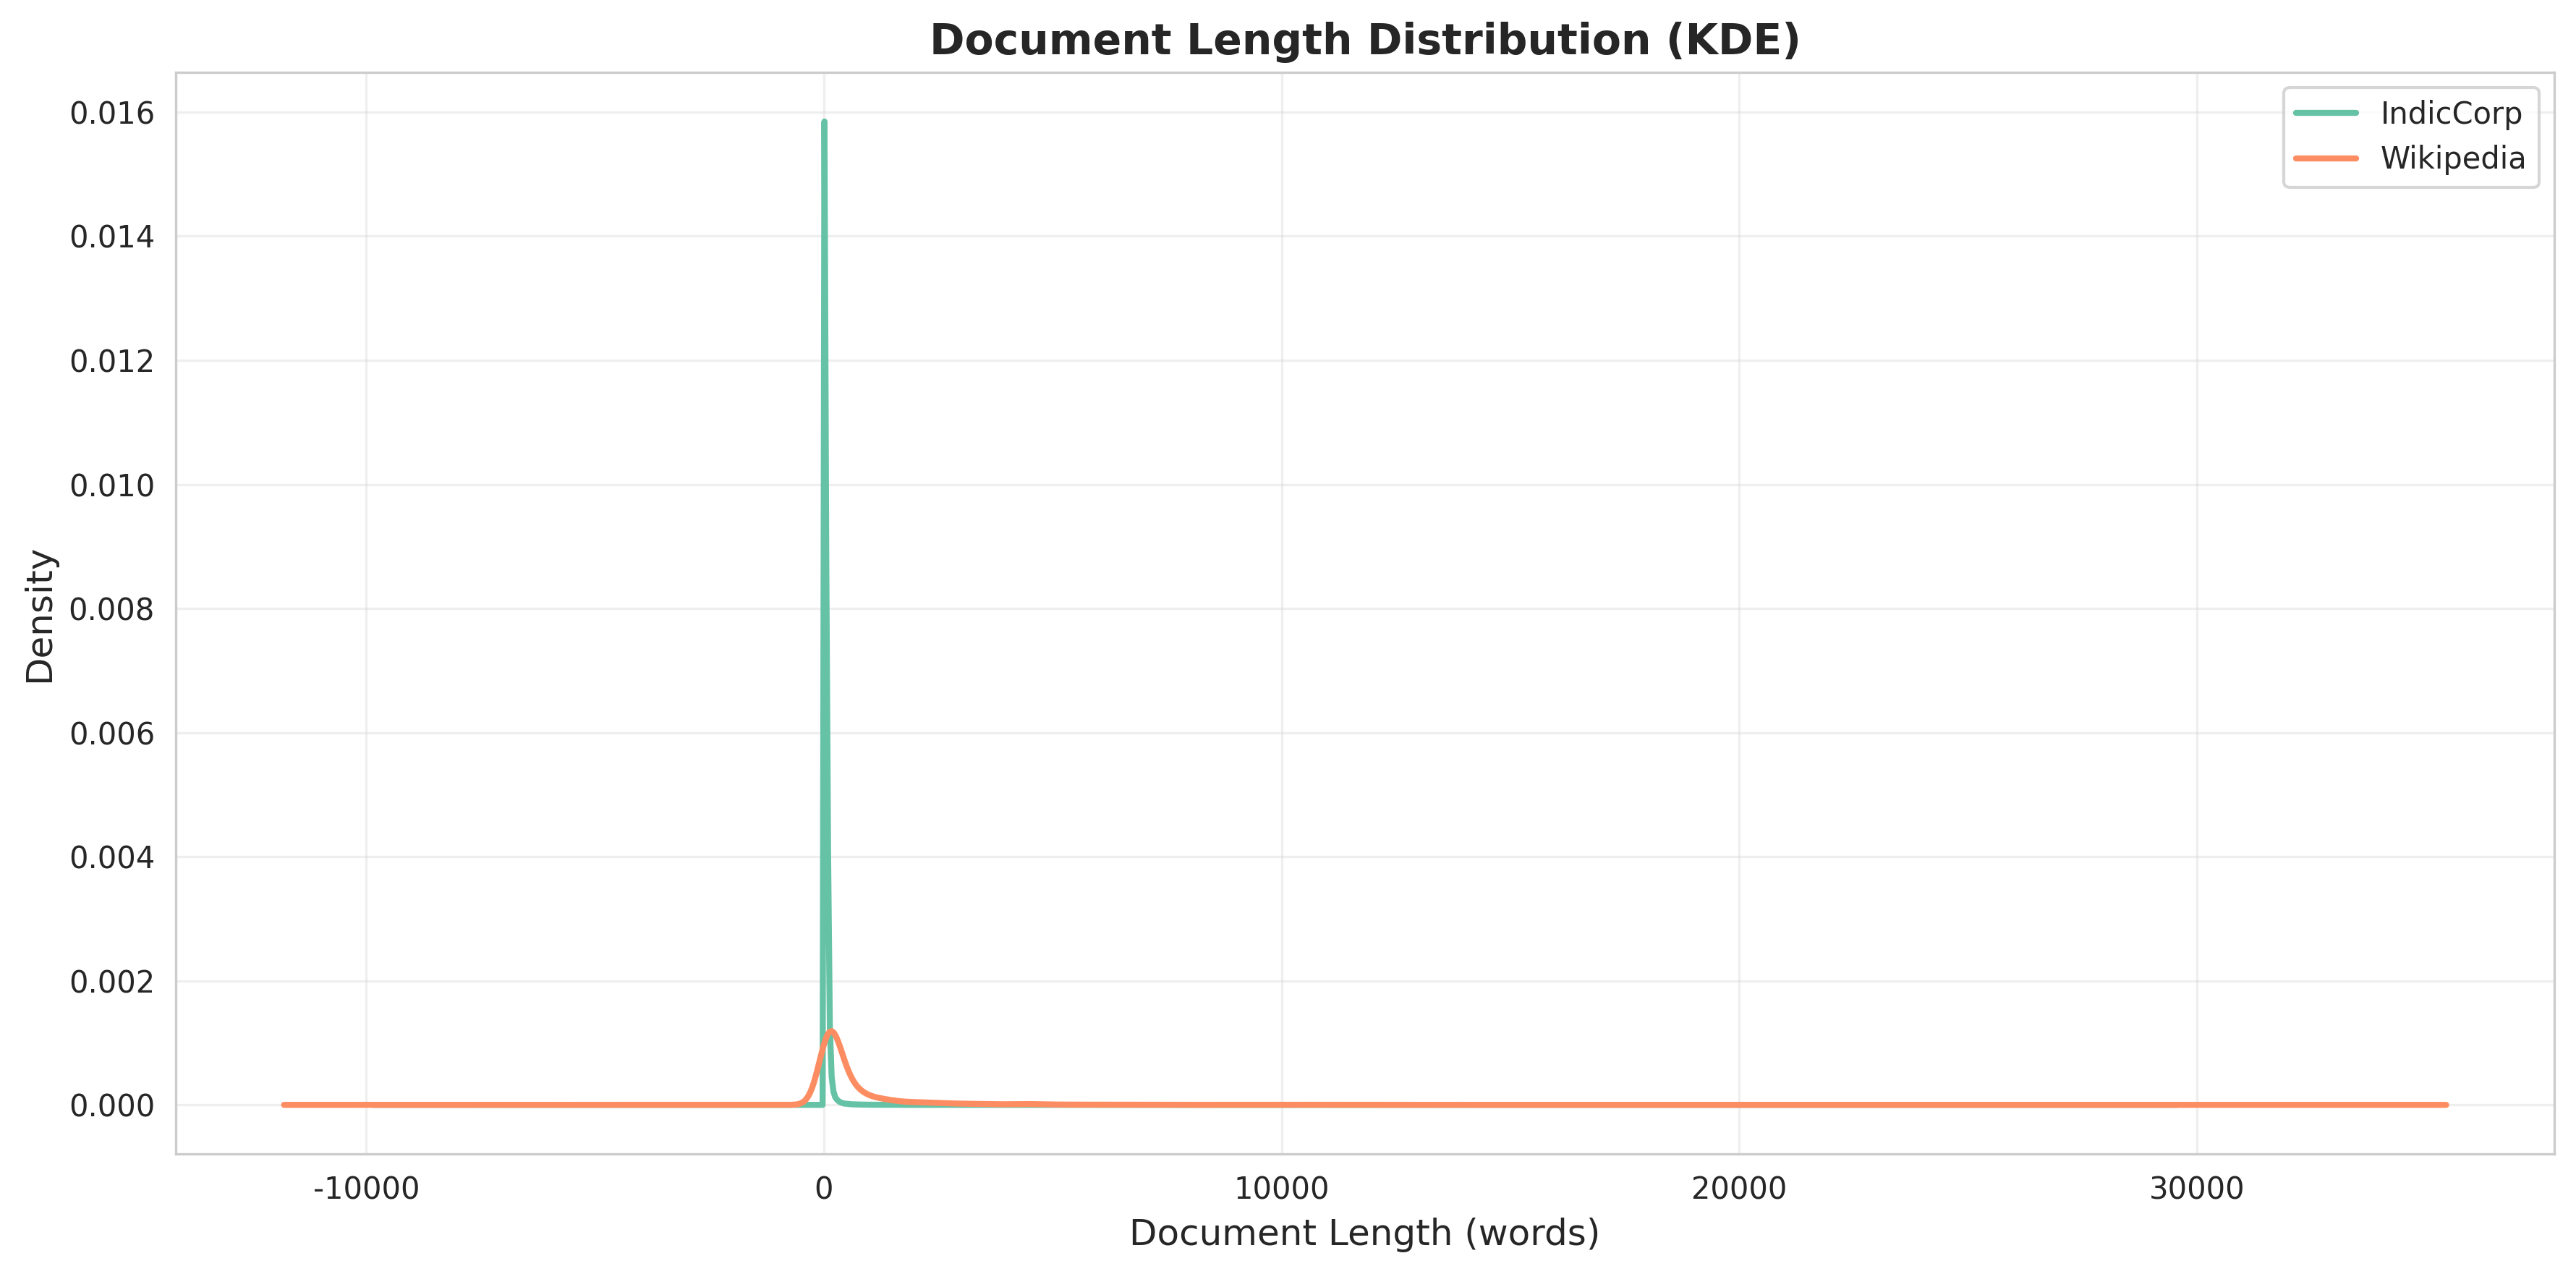

💾 Saved: /dss/dsshome1/00/ge95xod2/Hindi-BabyLM-Data-Efficient-Language-Modeling-for-Hindi/figures/length_dist_box.png


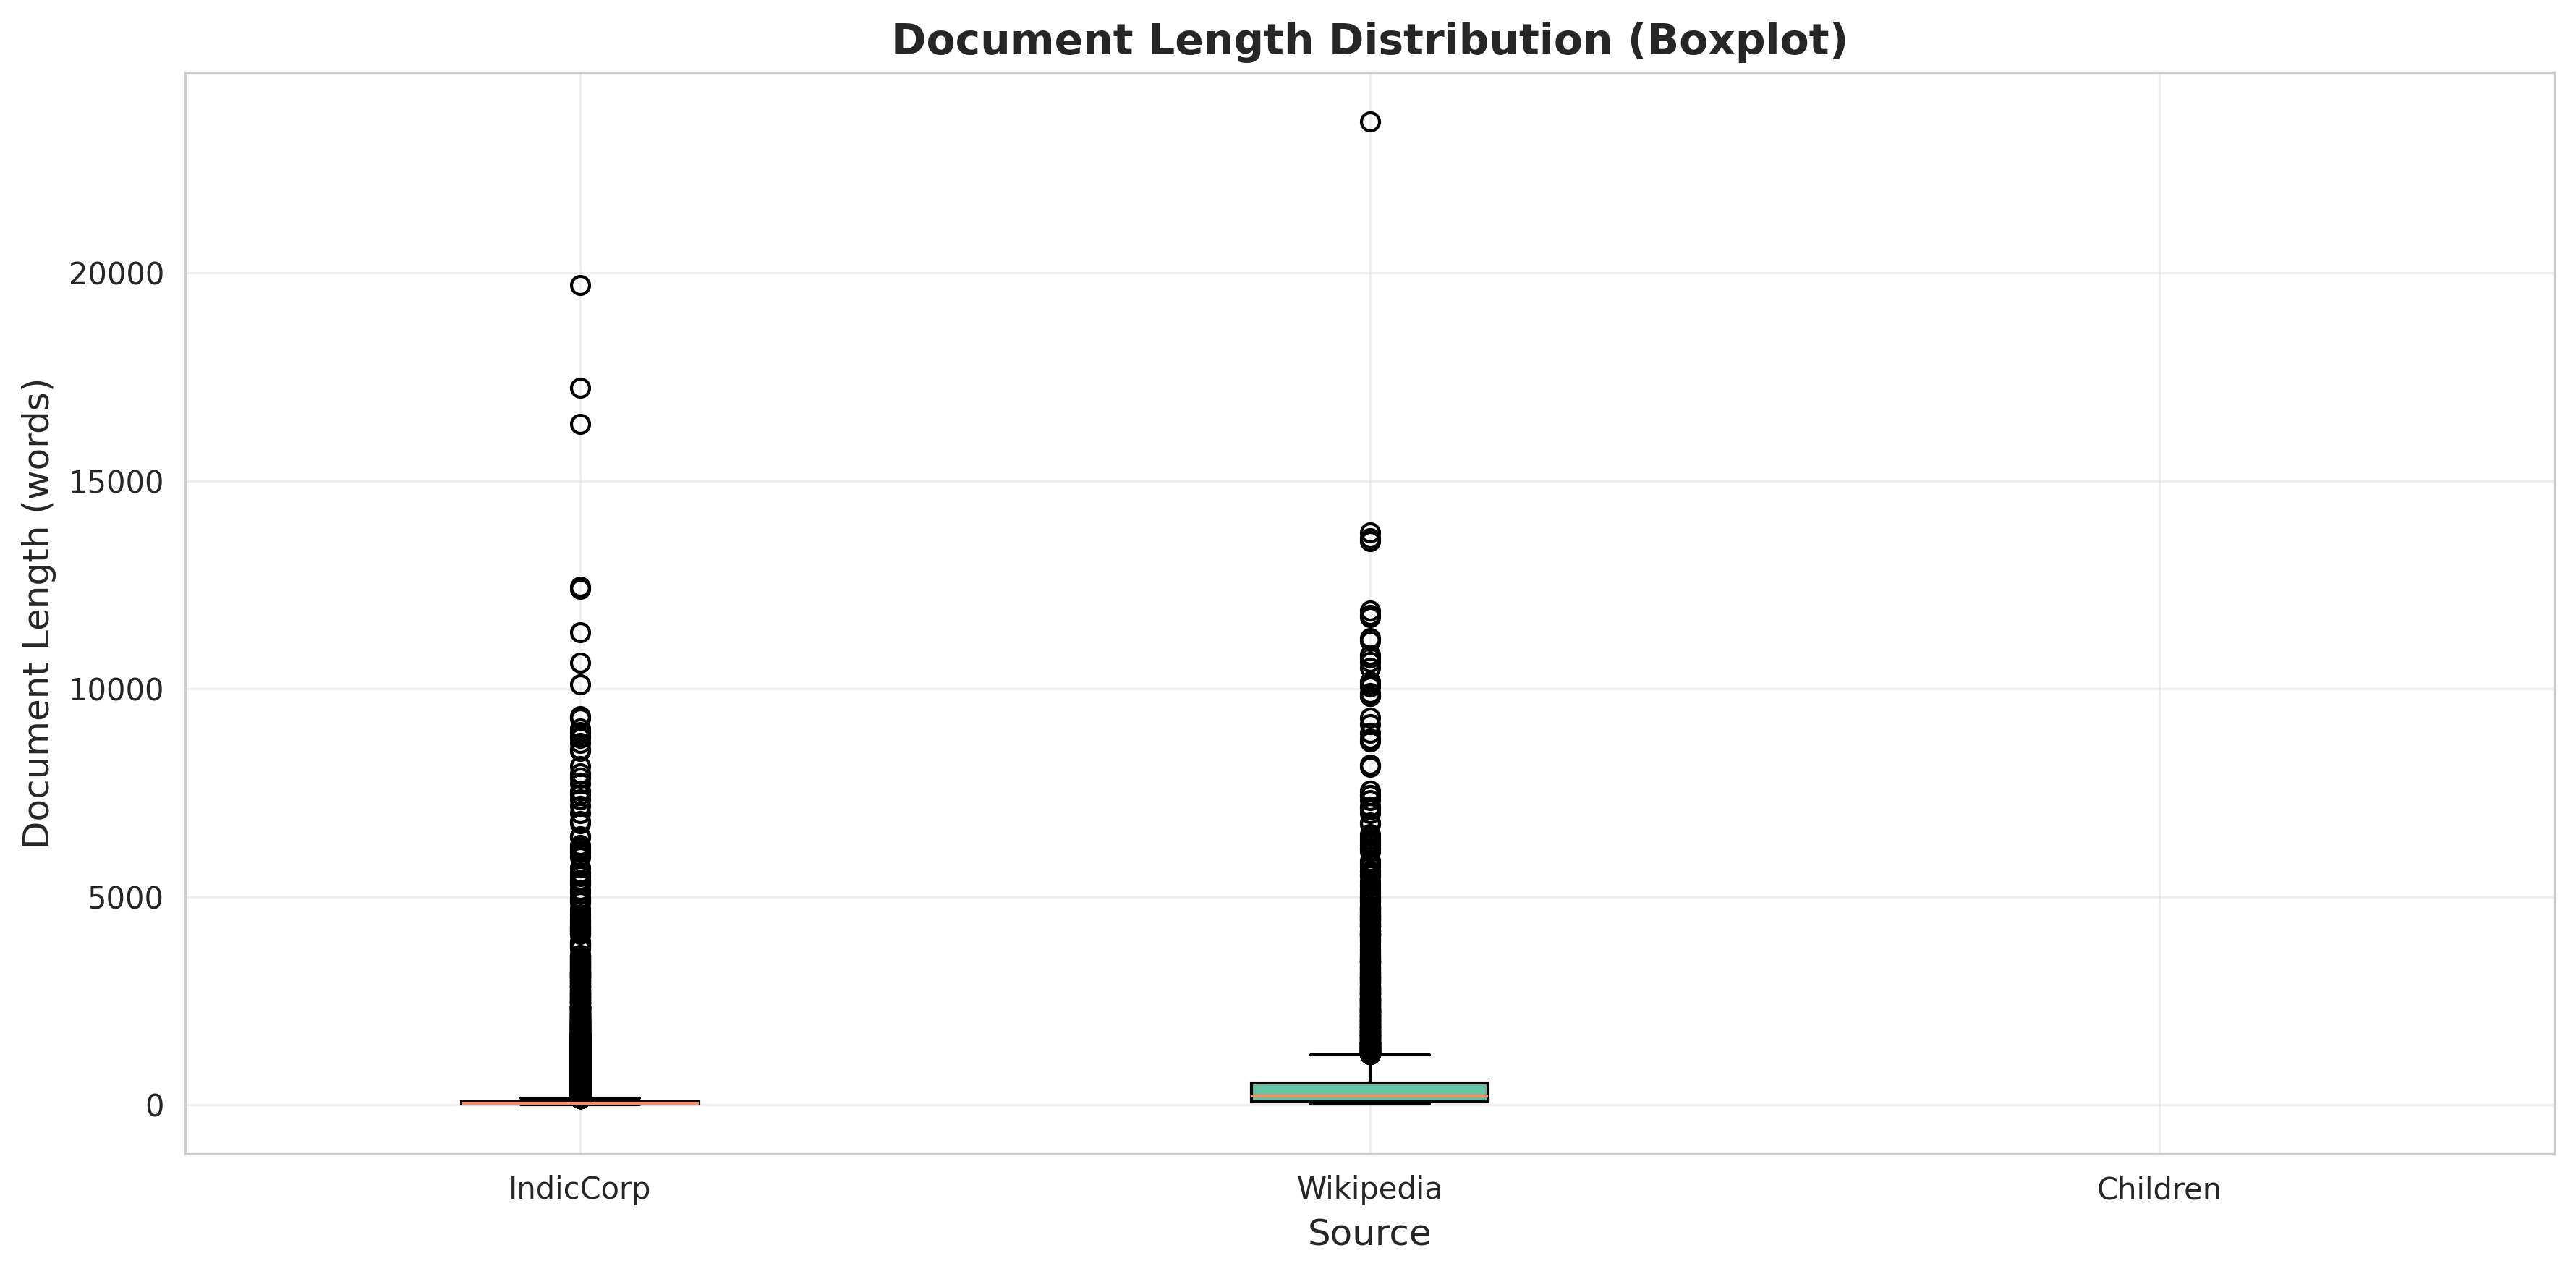

✅ Distribution plots saved


In [19]:
# ============================================================================
# DOCUMENT LENGTH DISTRIBUTIONS WITH MULTIPLE VISUALIZATIONS
# ============================================================================

print("📊 Analyzing document length distributions...\n")

# Extract word counts per source
length_data = {}
for source_name, texts in sources.items():
    word_counts = [len(text.split()) for text in texts]
    length_data[source_name] = word_counts

# Create visualizations
plot_comparison(
    length_data,
    'Document Length Distribution Across Sources',
    xlabel='Document Length (words)',
    ylabel='Frequency',
    plot_type='hist',
    save_path=FIGURES_DIR / 'length_dist_hist.png'
)

plot_comparison(
    length_data,
    'Document Length Distribution (KDE)',
    xlabel='Document Length (words)',
    ylabel='Density',
    plot_type='kde',
    save_path=FIGURES_DIR / 'length_dist_kde.png'
)

plot_comparison(
    length_data,
    'Document Length Distribution (Boxplot)',
    xlabel='Source',
    ylabel='Document Length (words)',
    plot_type='box',
    save_path=FIGURES_DIR / 'length_dist_box.png'
)

print("✅ Distribution plots saved")


📈 Analyzing vocabulary growth (Heap's Law)...



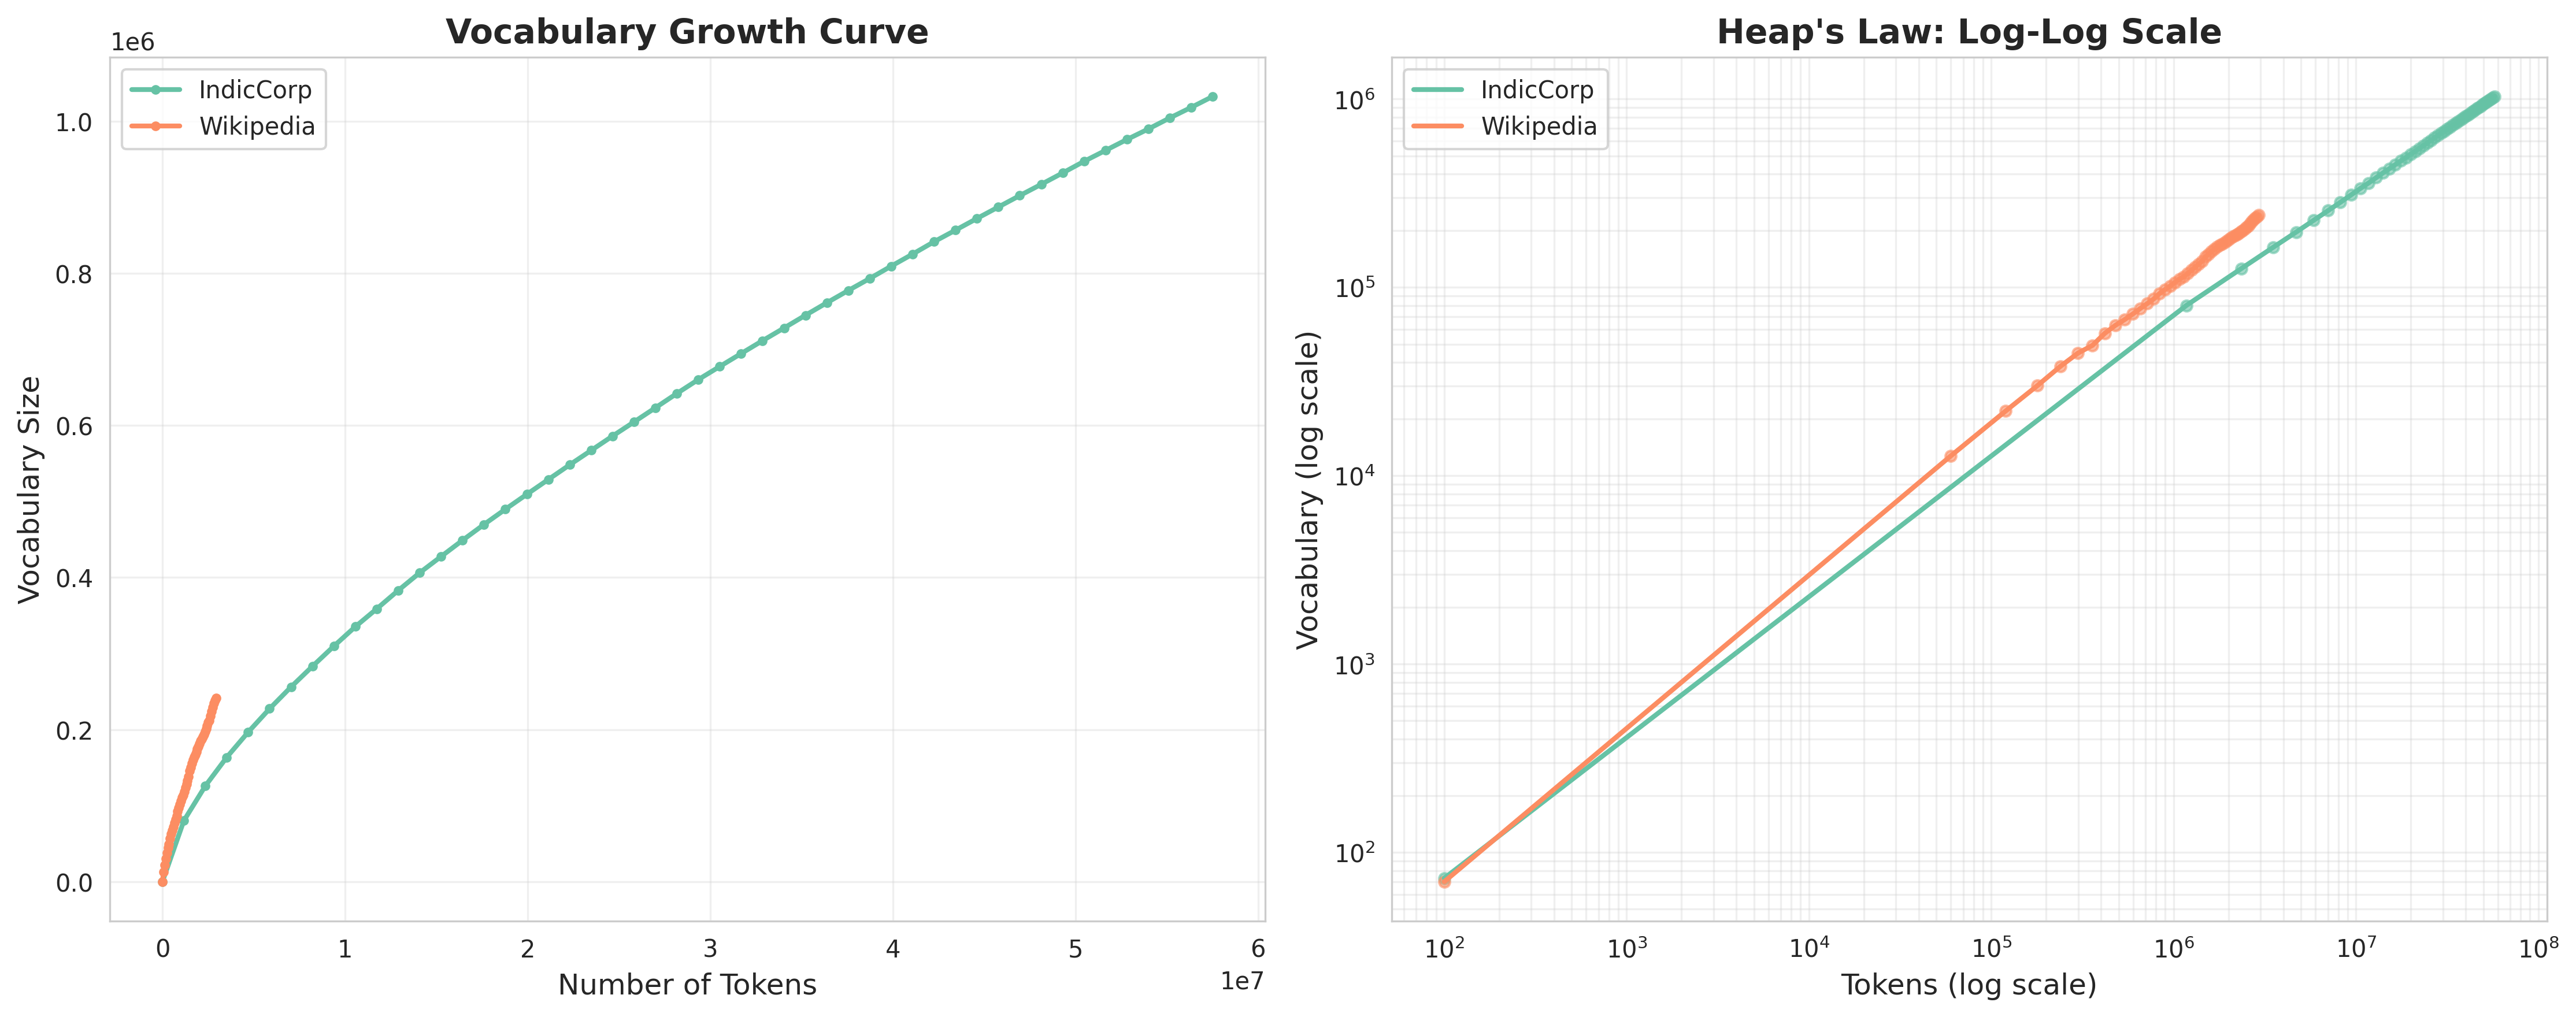

✅ Vocabulary growth curves saved


In [20]:
# ============================================================================
# VOCABULARY GROWTH CURVES (HEAP'S LAW)
# ============================================================================

print("\n📈 Analyzing vocabulary growth (Heap's Law)...\n")

def compute_vocab_growth(texts, sample_points=50):
    """Compute vocabulary growth curve."""
    all_words = [word for text in texts for word in text.split()]

    if not all_words:
        return [], []

    total = len(all_words)
    sample_indices = np.linspace(100, total, min(sample_points, max(1, total // 10)), dtype=int)

    vocab_sizes = []
    token_counts = []
    seen_words = set()

    for idx in sample_indices:
        seen_words.update(all_words[:idx])
        vocab_sizes.append(len(seen_words))
        token_counts.append(idx)

    return token_counts, vocab_sizes

# Compute and plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
colors = sns.color_palette('Set2', len(sources))

for (source, texts), color in zip(sources.items(), colors):
    tokens, vocab = compute_vocab_growth(texts)
    if tokens:
        ax1.plot(tokens, vocab, marker='o', markersize=3, label=source, color=color, linewidth=2)
        ax2.scatter(tokens, vocab, alpha=0.6, color=color, s=20)
        ax2.plot(tokens, vocab, label=source, color=color, linewidth=2)

ax1.set_xlabel('Number of Tokens')
ax1.set_ylabel('Vocabulary Size')
ax1.set_title("Vocabulary Growth Curve", fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Tokens (log scale)')
ax2.set_ylabel('Vocabulary (log scale)')
ax2.set_title("Heap's Law: Log-Log Scale", fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'vocabulary_growth.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Vocabulary growth curves saved")

---
## Section 4: Deep Character & Script Analysis

Comprehensive analysis of Unicode blocks, Devanagari characters, matras (vowel diacritics), and script mixing.

🔤 Analyzing Unicode blocks...



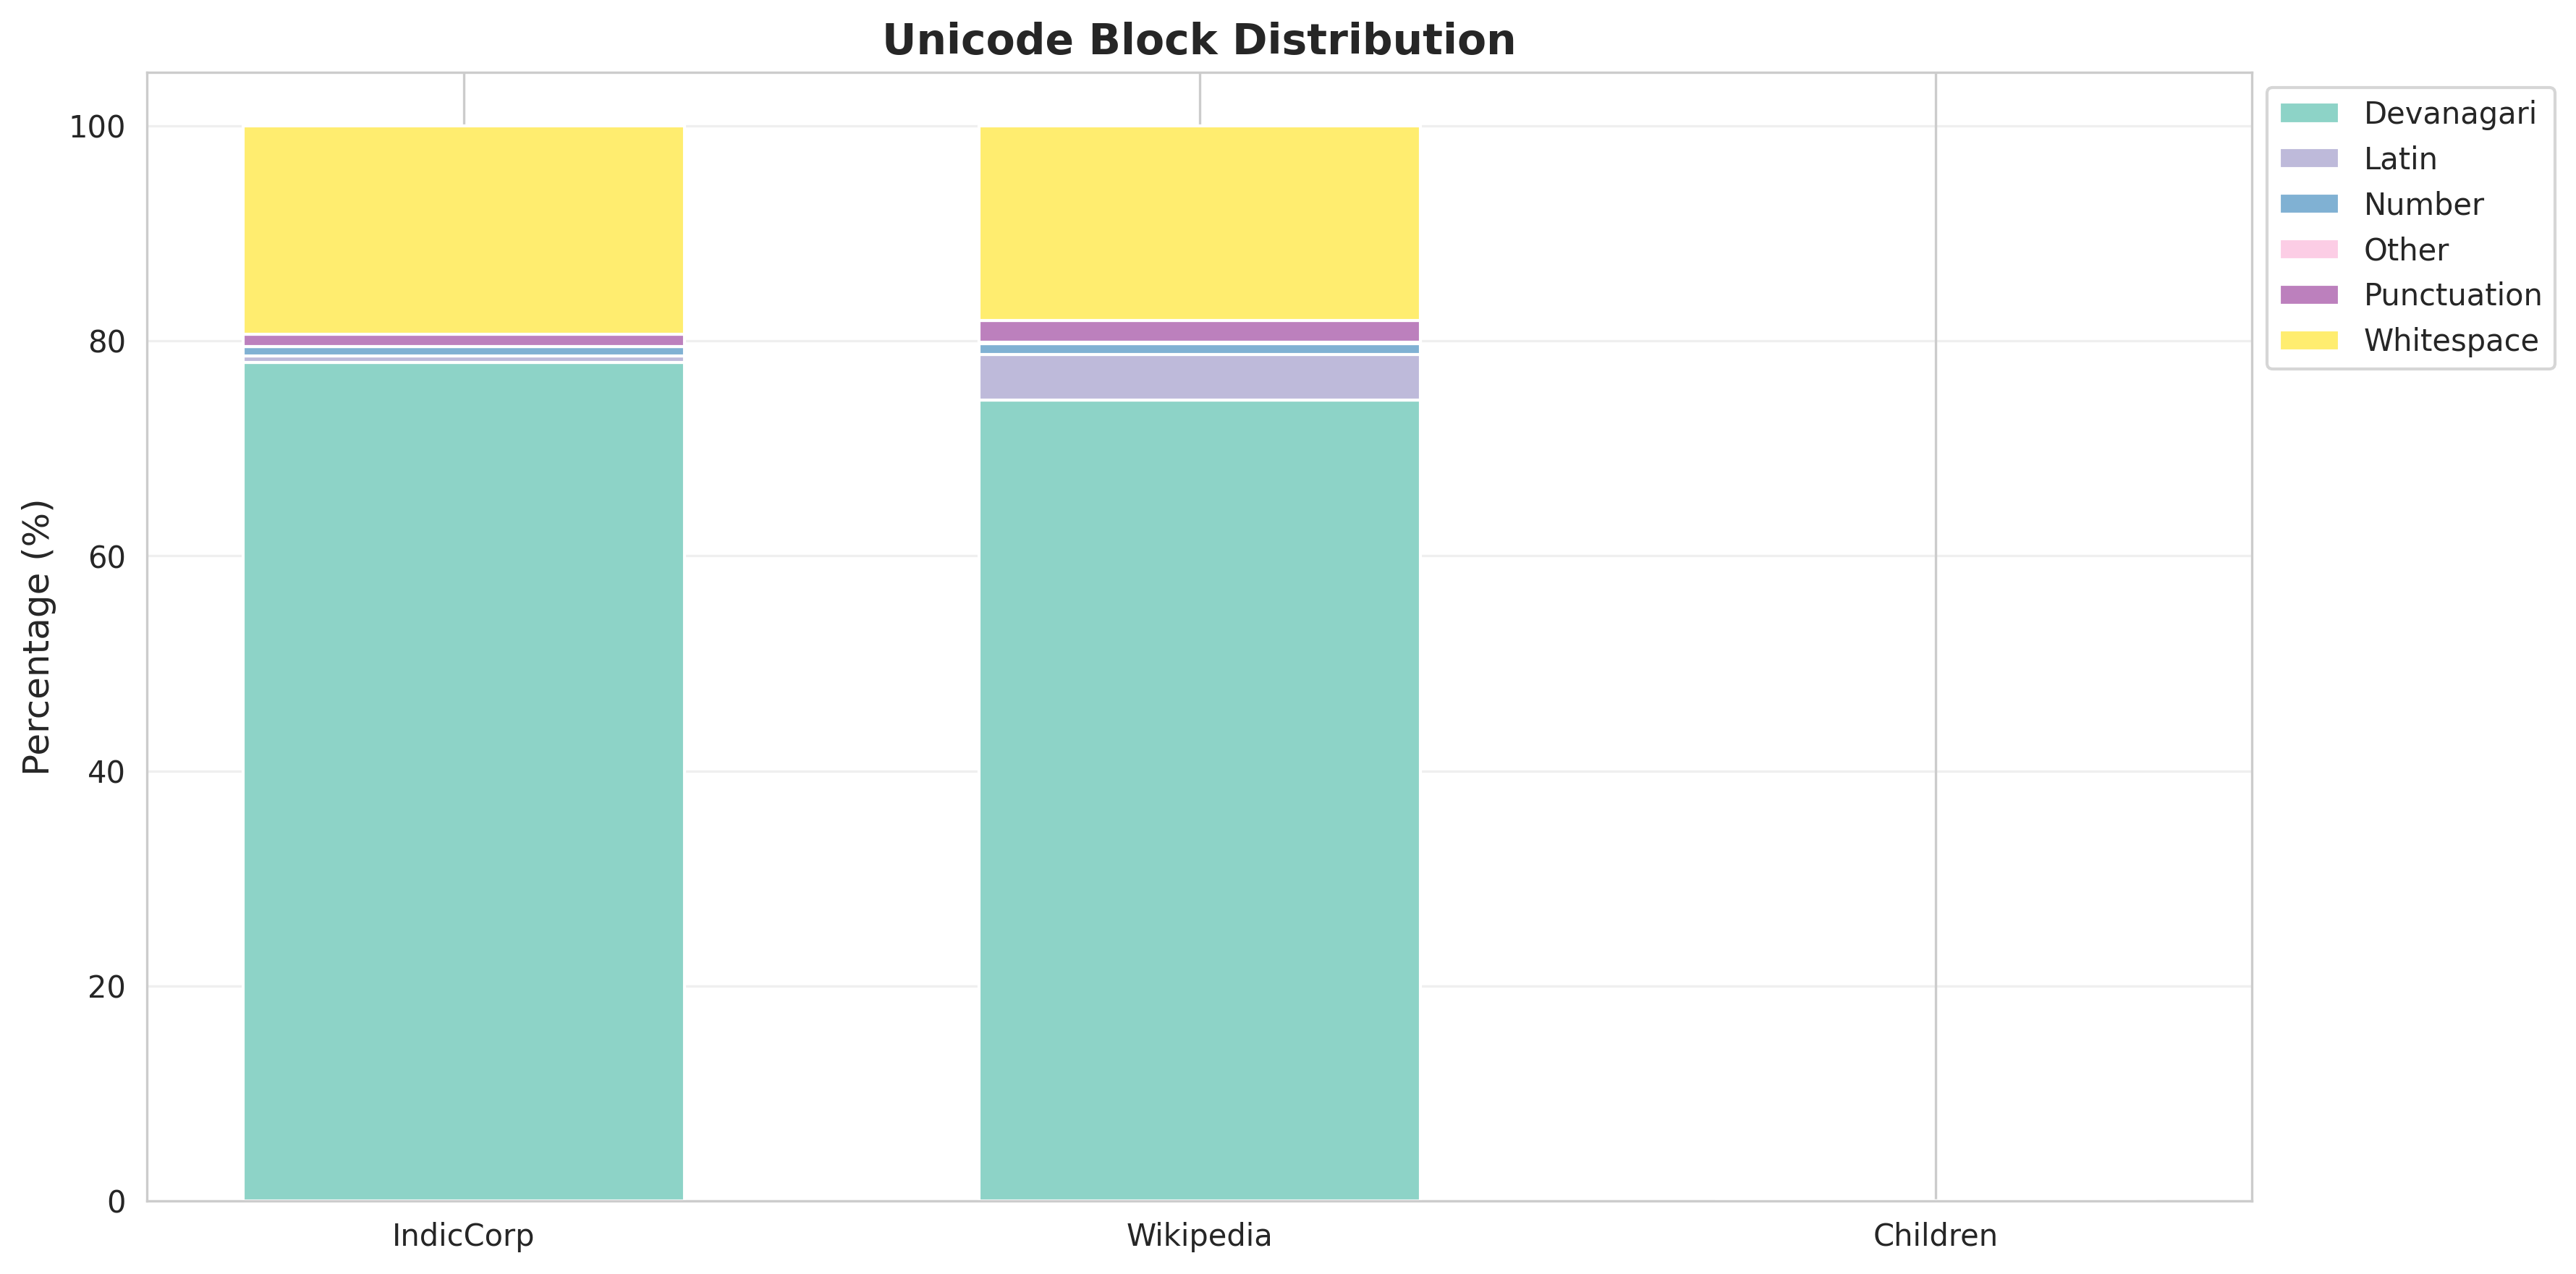

✅ Unicode block analysis complete


In [21]:
# ============================================================================
# UNICODE BLOCK ANALYSIS
# ============================================================================

print("🔤 Analyzing Unicode blocks...\n")

def analyze_unicode_blocks(texts):
    all_text = ''.join(texts)
    block_counts = Counter()
    for char in all_text:
        block = get_unicode_block(char)
        block_counts[block] += 1
    return block_counts

unicode_stats = {}
for source, texts in sources.items():
    unicode_stats[source] = analyze_unicode_blocks(texts)

# Visualize
all_blocks = set()
for stats in unicode_stats.values():
    all_blocks.update(stats.keys())
all_blocks = sorted(all_blocks)

fig, ax = plt.subplots(figsize=(12, 6))
source_names = list(unicode_stats.keys())
x = np.arange(len(source_names))
width = 0.6
bottom = np.zeros(len(source_names))

colors_blocks = plt.cm.Set3(np.linspace(0, 1, len(all_blocks)))

for block, color in zip(all_blocks, colors_blocks):
    block_pcts = []
    for source in source_names:
        total = sum(unicode_stats[source].values())
        pct = (unicode_stats[source].get(block, 0) / total * 100) if total > 0 else 0
        block_pcts.append(pct)
    ax.bar(x, block_pcts, width, label=block, bottom=bottom, color=color)
    bottom += block_pcts

ax.set_ylabel('Percentage (%)')
ax.set_title('Unicode Block Distribution', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(source_names)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'unicode_blocks.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Unicode block analysis complete")


🔠 Analyzing Devanagari characters...



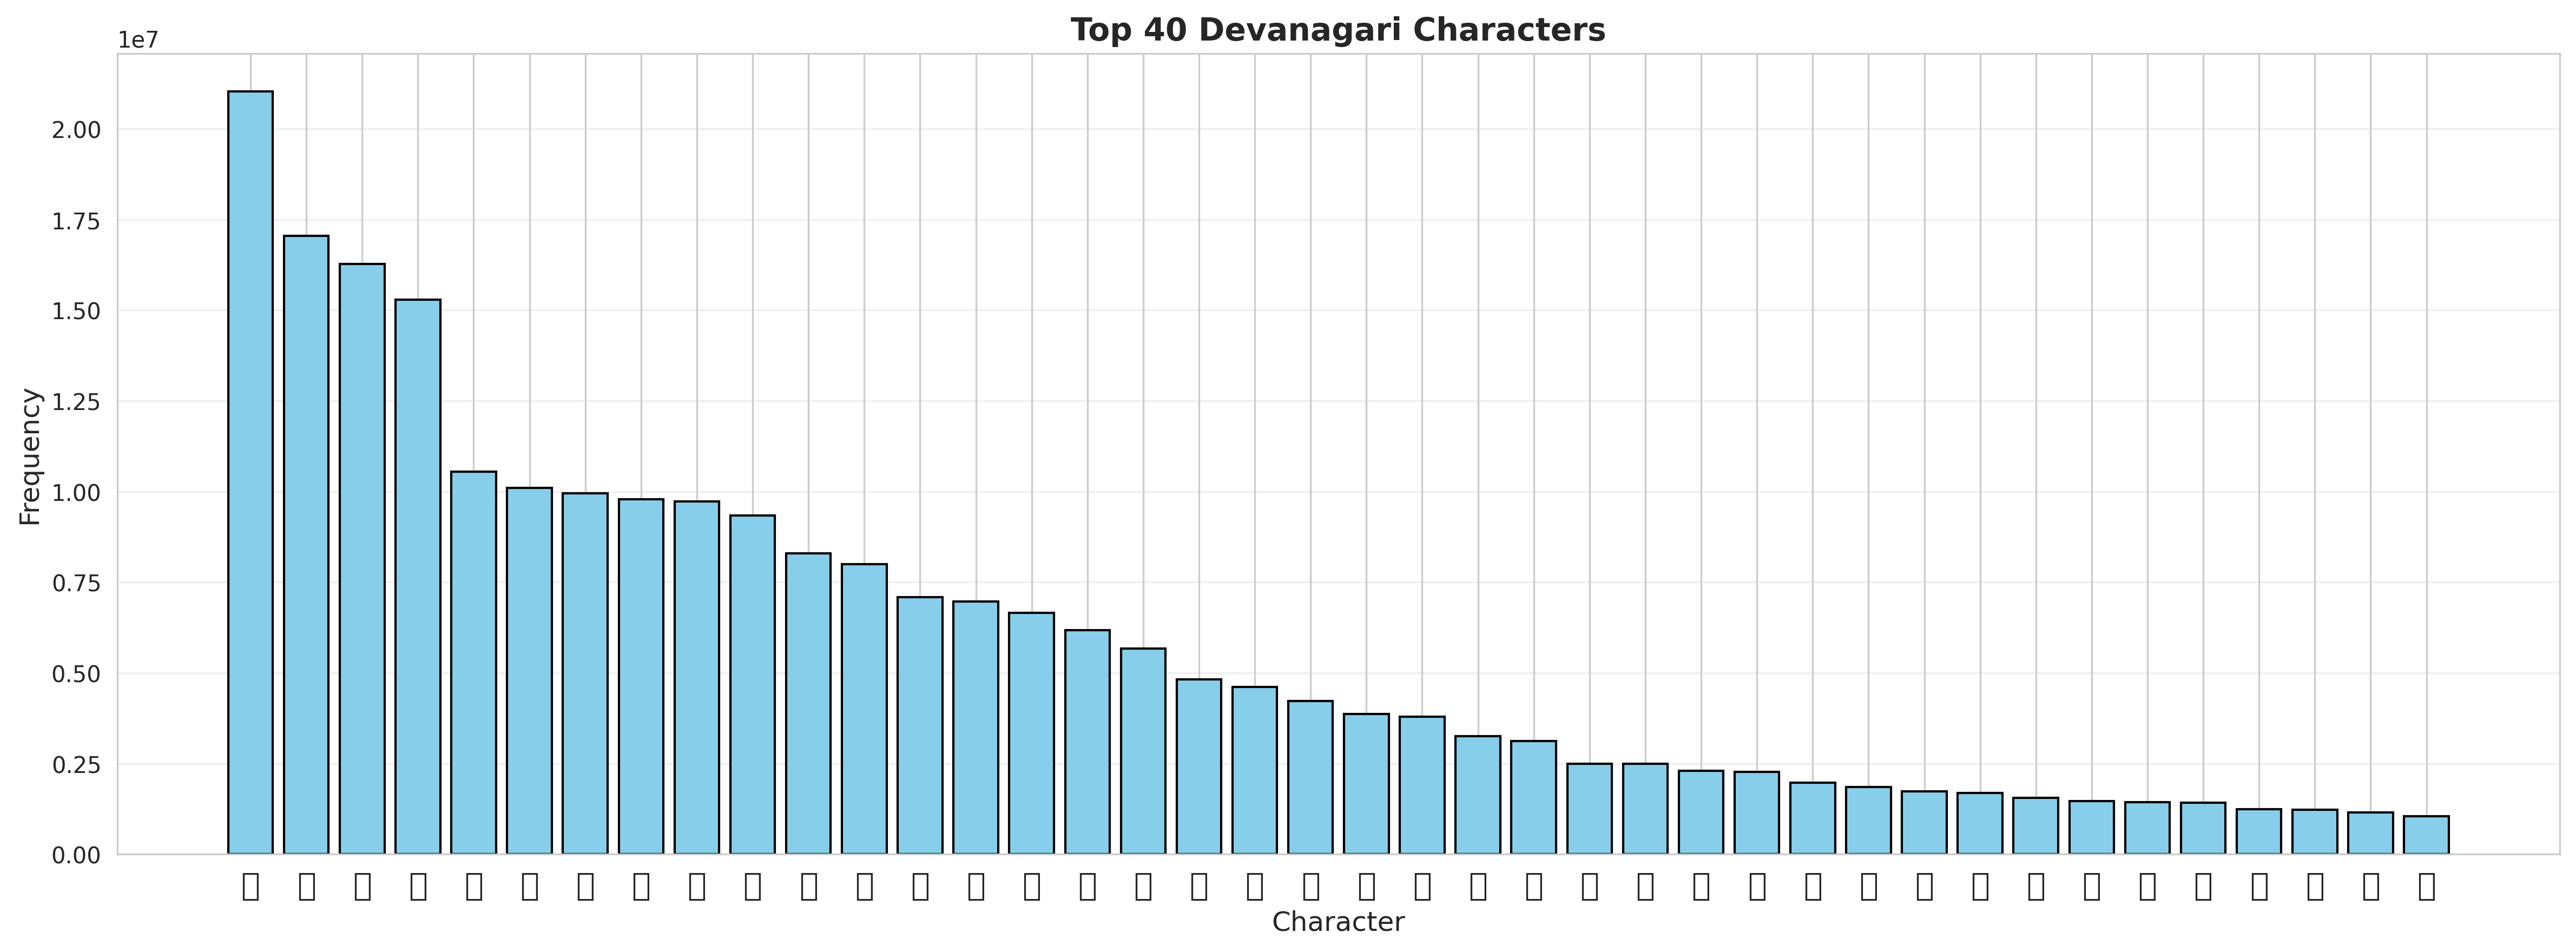

Total unique Devanagari characters: 110


In [22]:
# ============================================================================
# DEVANAGARI CHARACTER FREQUENCY
# ============================================================================

print("\n🔠 Analyzing Devanagari characters...\n")

all_devanagari = Counter()
for texts in sources.values():
    for char in ''.join(texts):
        if is_devanagari(char):
            all_devanagari[char] += 1

top_chars = all_devanagari.most_common(40)

if top_chars:
    chars, counts = zip(*top_chars)

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.bar(range(len(chars)), counts, color='skyblue', edgecolor='black')
    ax.set_xticks(range(len(chars)))
    ax.set_xticklabels(chars, fontsize=14)
    ax.set_xlabel('Character')
    ax.set_ylabel('Frequency')
    ax.set_title('Top 40 Devanagari Characters', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'devanagari_chars.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Total unique Devanagari characters: {len(all_devanagari)}")

---
## Section 5: Advanced Word-Level Analysis

Zipf's law validation, hapax legomena, OOV rates, and word length distributions.

📊 Validating Zipf's Law...



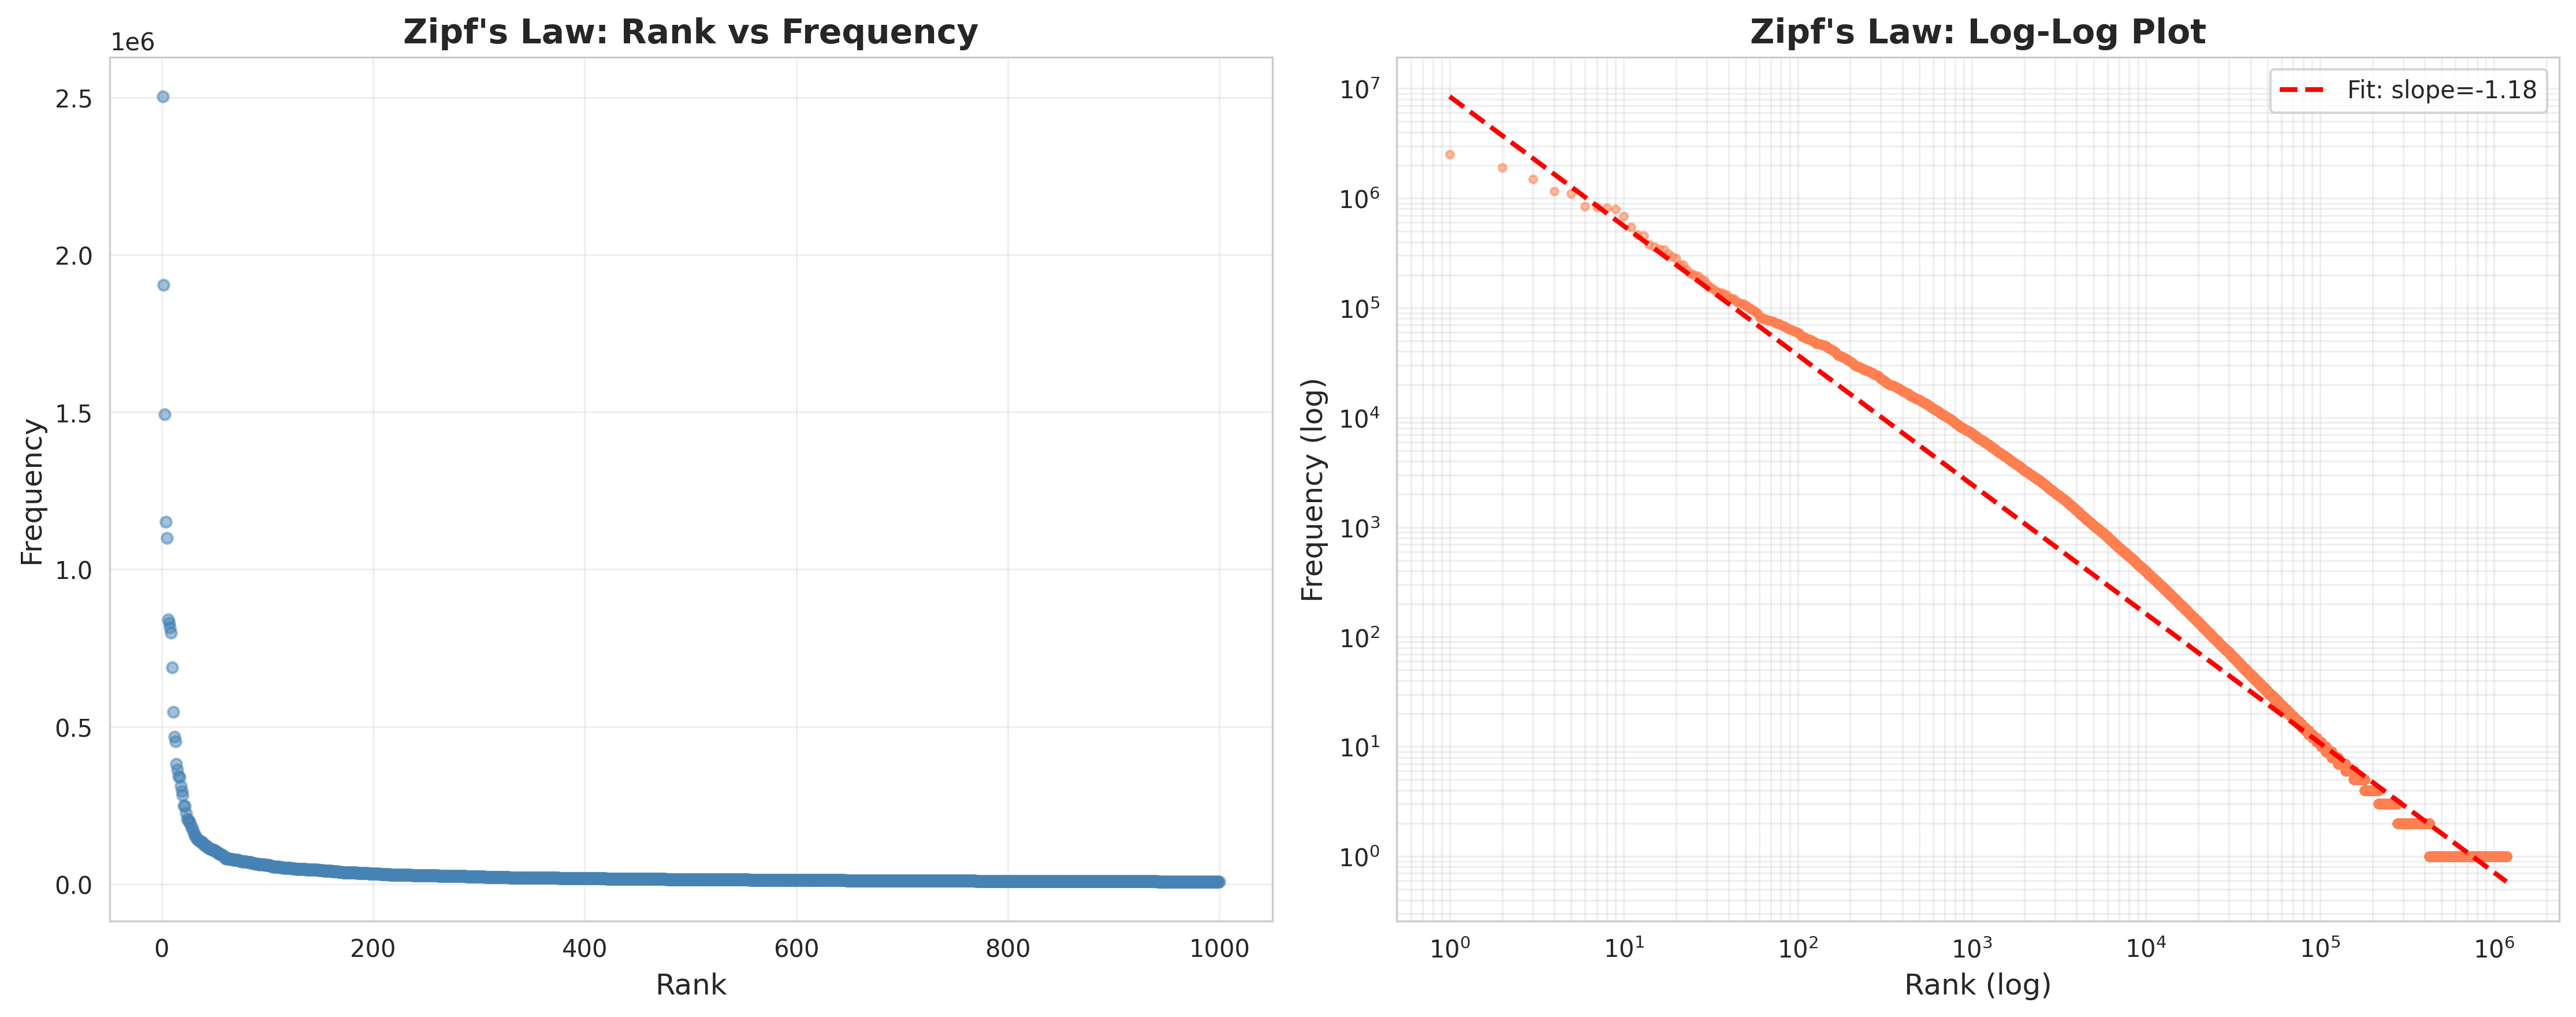

Zipf exponent: 1.179

Top 20 words:
   1. के              2,503,706
   2. में             1,904,368
   3. की              1,493,026
   4. को              1,151,586
   5. से              1,100,065
   6. का              840,571
   7. ने              830,642
   8. और              815,884
   9. है।             797,890
  10. पर              687,604
  11. कि              547,211
  12. भी              468,612
  13. है              453,453
  14. लिए             380,926
  15. एक              362,979
  16. इस              343,279
  17. कर              338,684
  18. नहीं            311,011
  19. हैं।            295,623
  20. ही              282,031


In [23]:
# ============================================================================
# ZIPF'S LAW VALIDATION
# ============================================================================

print("📊 Validating Zipf's Law...\n")

all_words = [word for texts in sources.values() for text in texts for word in text.split()]
word_freq = Counter(all_words)
sorted_words = word_freq.most_common()

if sorted_words:
    ranks = np.arange(1, len(sorted_words) + 1)
    frequencies = np.array([freq for word, freq in sorted_words])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Regular scale
    ax1.scatter(ranks[:1000], frequencies[:1000], alpha=0.5, s=20, color='steelblue')
    ax1.set_xlabel('Rank')
    ax1.set_ylabel('Frequency')
    ax1.set_title("Zipf's Law: Rank vs Frequency", fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Log-log scale
    ax2.scatter(ranks, frequencies, alpha=0.5, s=10, color='coral')
    log_ranks = np.log(ranks)
    log_freqs = np.log(frequencies)
    slope, intercept = np.polyfit(log_ranks, log_freqs, 1)
    fitted = np.exp(intercept + slope * log_ranks)
    ax2.plot(ranks, fitted, 'r--', linewidth=2, label=f'Fit: slope={slope:.2f}')

    ax2.set_xlabel('Rank (log)')
    ax2.set_ylabel('Frequency (log)')
    ax2.set_title("Zipf's Law: Log-Log Plot", fontweight='bold')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3, which='both')

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'zipf_law.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Zipf exponent: {-slope:.3f}")
    print("\nTop 20 words:")
    for i, (word, freq) in enumerate(sorted_words[:20], 1):
        print(f"  {i:2d}. {word:15s} {freq:>6,}")


📖 Analyzing hapax legomena...

           hapax_count  hapax_pct  dis_count    dis_pct
IndicCorp     653639.0  63.303069   126249.0  12.226855
Wikipedia     159104.0  65.797113    30696.0  12.694264
Children           0.0   0.000000        0.0   0.000000


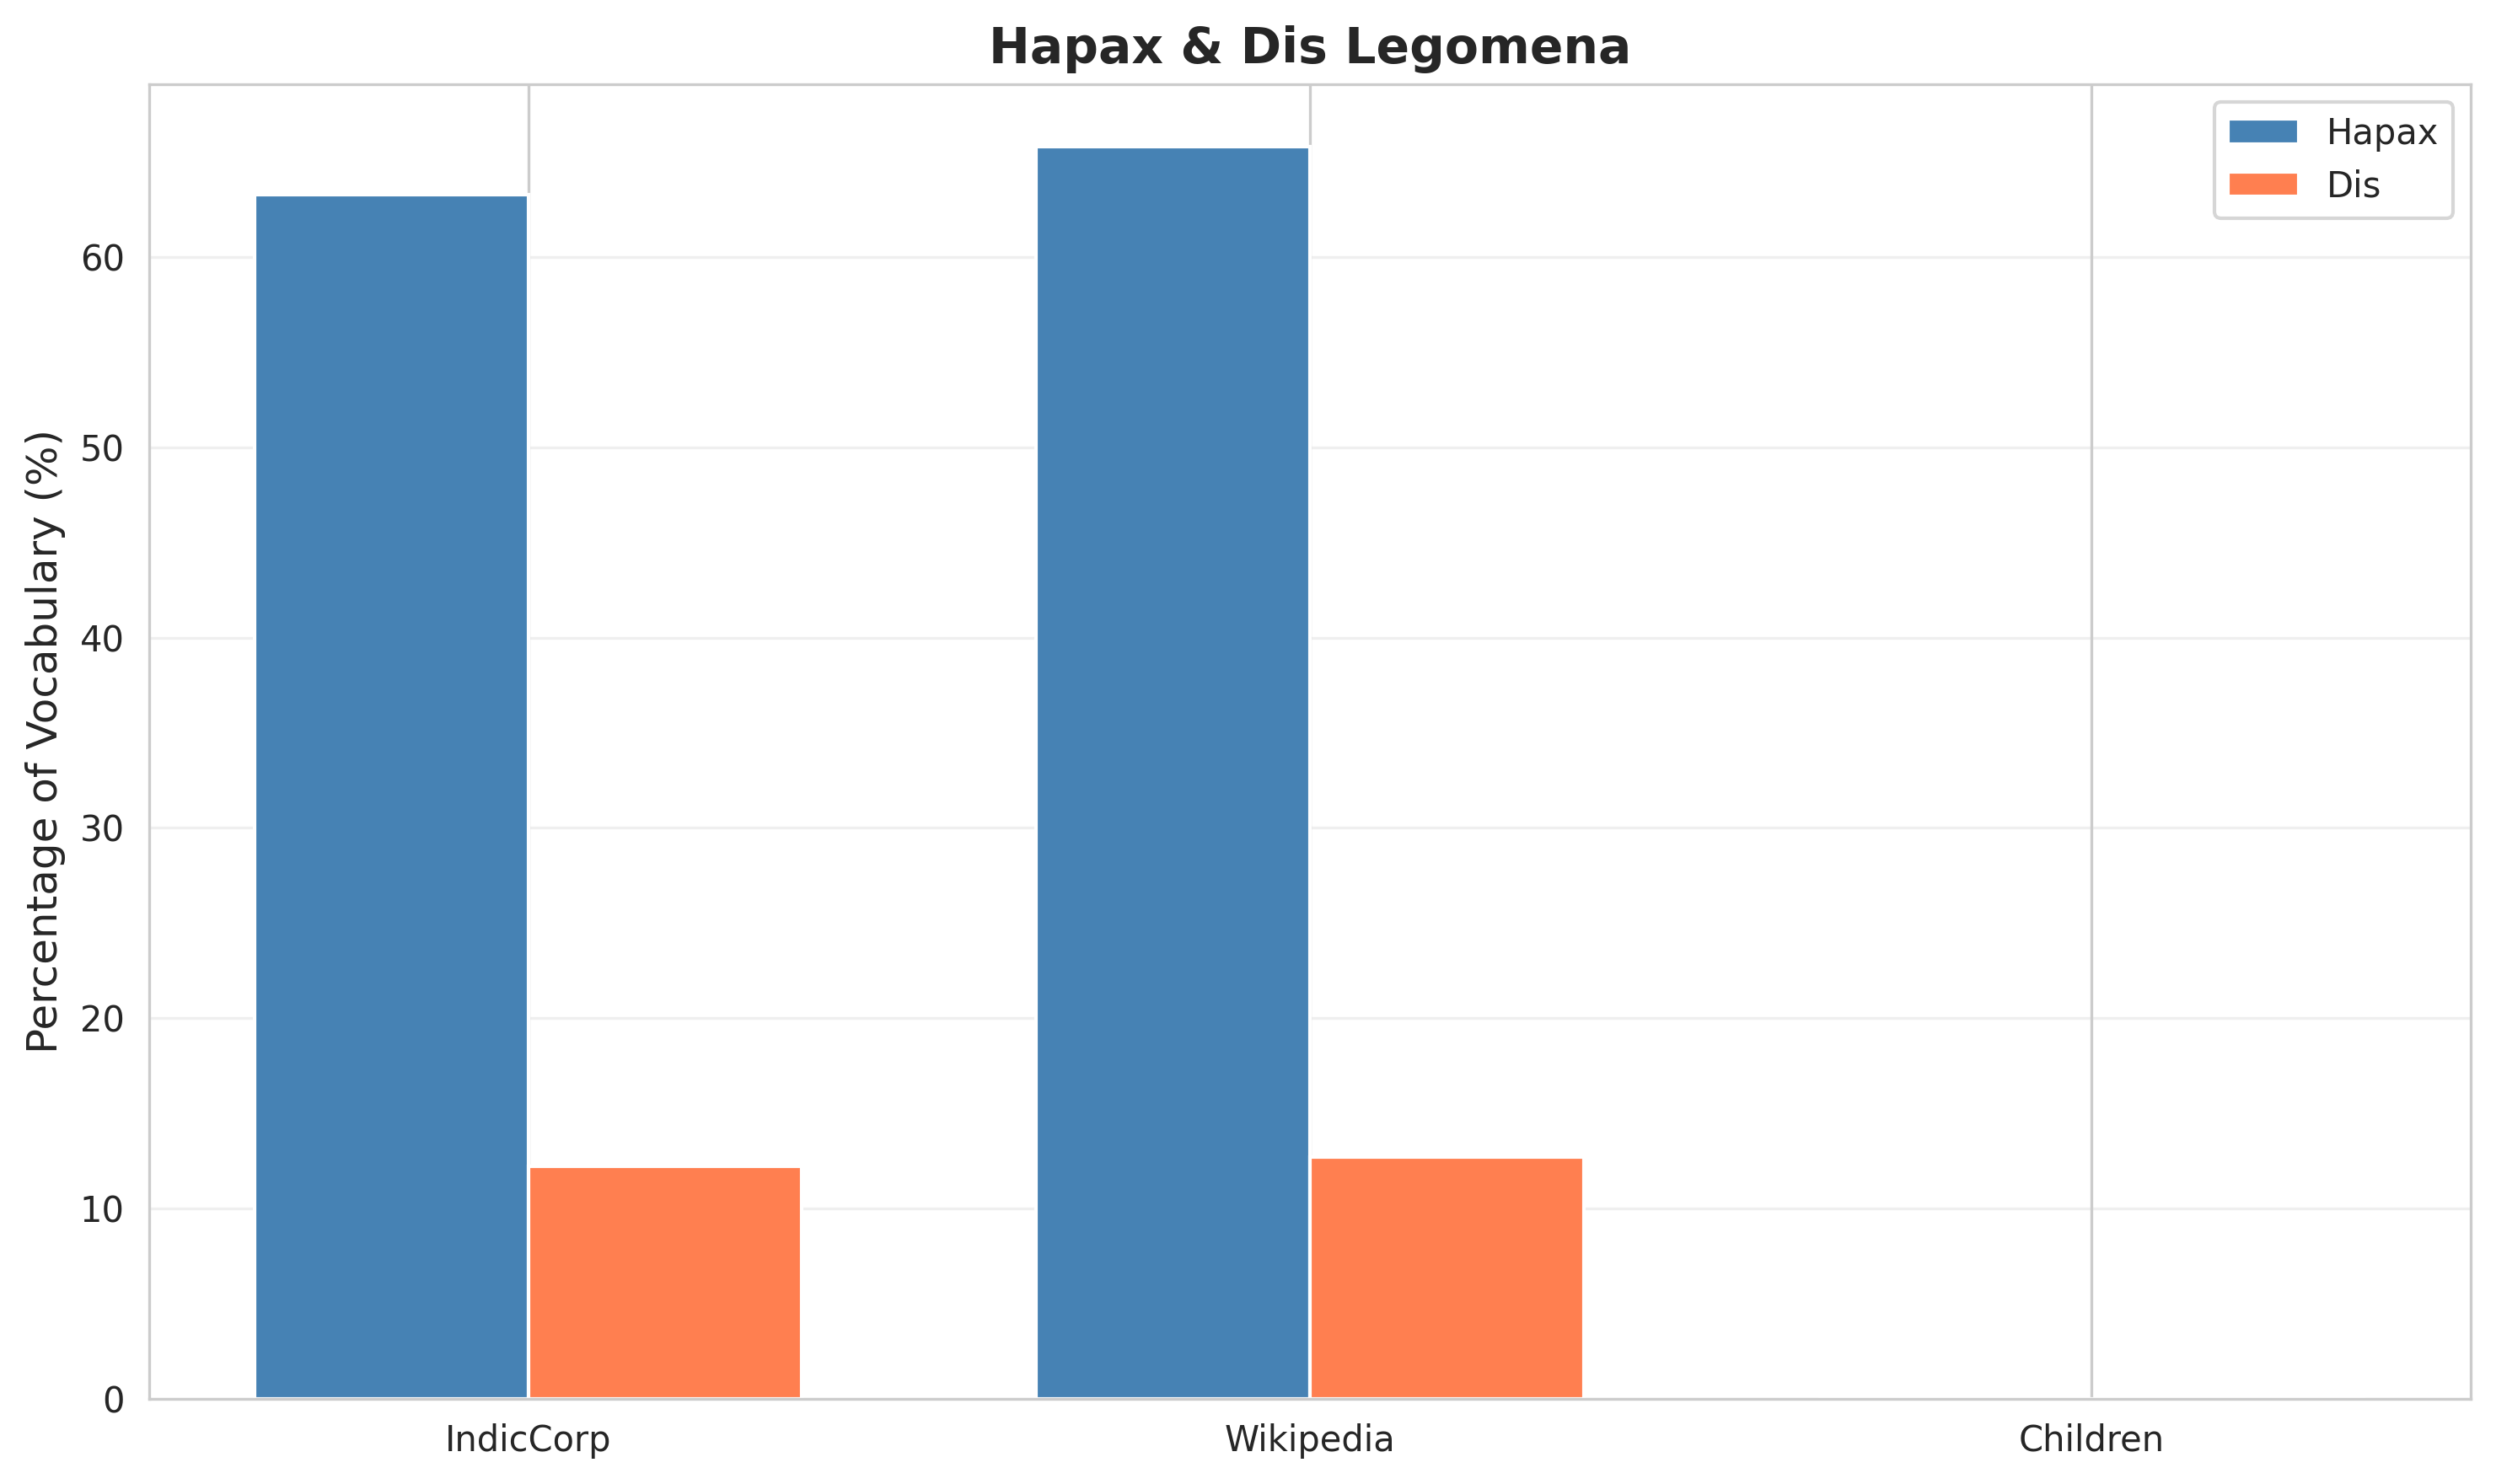

In [24]:
# ============================================================================
# HAPAX LEGOMENA ANALYSIS
# ============================================================================

print("\n📖 Analyzing hapax legomena...\n")

hapax_stats = {}
for source, texts in sources.items():
    words = [word for text in texts for word in text.split()]
    word_counts = Counter(words)

    hapax = [w for w, c in word_counts.items() if c == 1]
    dis = [w for w, c in word_counts.items() if c == 2]

    total_types = len(word_counts)
    hapax_stats[source] = {
        'hapax_count': len(hapax),
        'hapax_pct': len(hapax) / total_types * 100 if total_types > 0 else 0,
        'dis_count': len(dis),
        'dis_pct': len(dis) / total_types * 100 if total_types > 0 else 0,
    }

df_hapax = pd.DataFrame(hapax_stats).T
print(df_hapax.to_string())

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(sources))
width = 0.35

source_names = list(sources.keys())
hapax_pcts = [hapax_stats[s]['hapax_pct'] for s in source_names]
dis_pcts = [hapax_stats[s]['dis_pct'] for s in source_names]

bars1 = ax.bar(x - width/2, hapax_pcts, width, label='Hapax', color='steelblue')
bars2 = ax.bar(x + width/2, dis_pcts, width, label='Dis', color='coral')

ax.set_ylabel('Percentage of Vocabulary (%)')
ax.set_title('Hapax & Dis Legomena', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(source_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'hapax_legomena.png', dpi=300, bbox_inches='tight')
plt.show()


🔍 Calculating OOV rates...

Training vocabulary: 1,658 types
Test vocabulary: 1,500 types
OOV types: 1,008 (67.20%)
OOV token rate: 36.70%


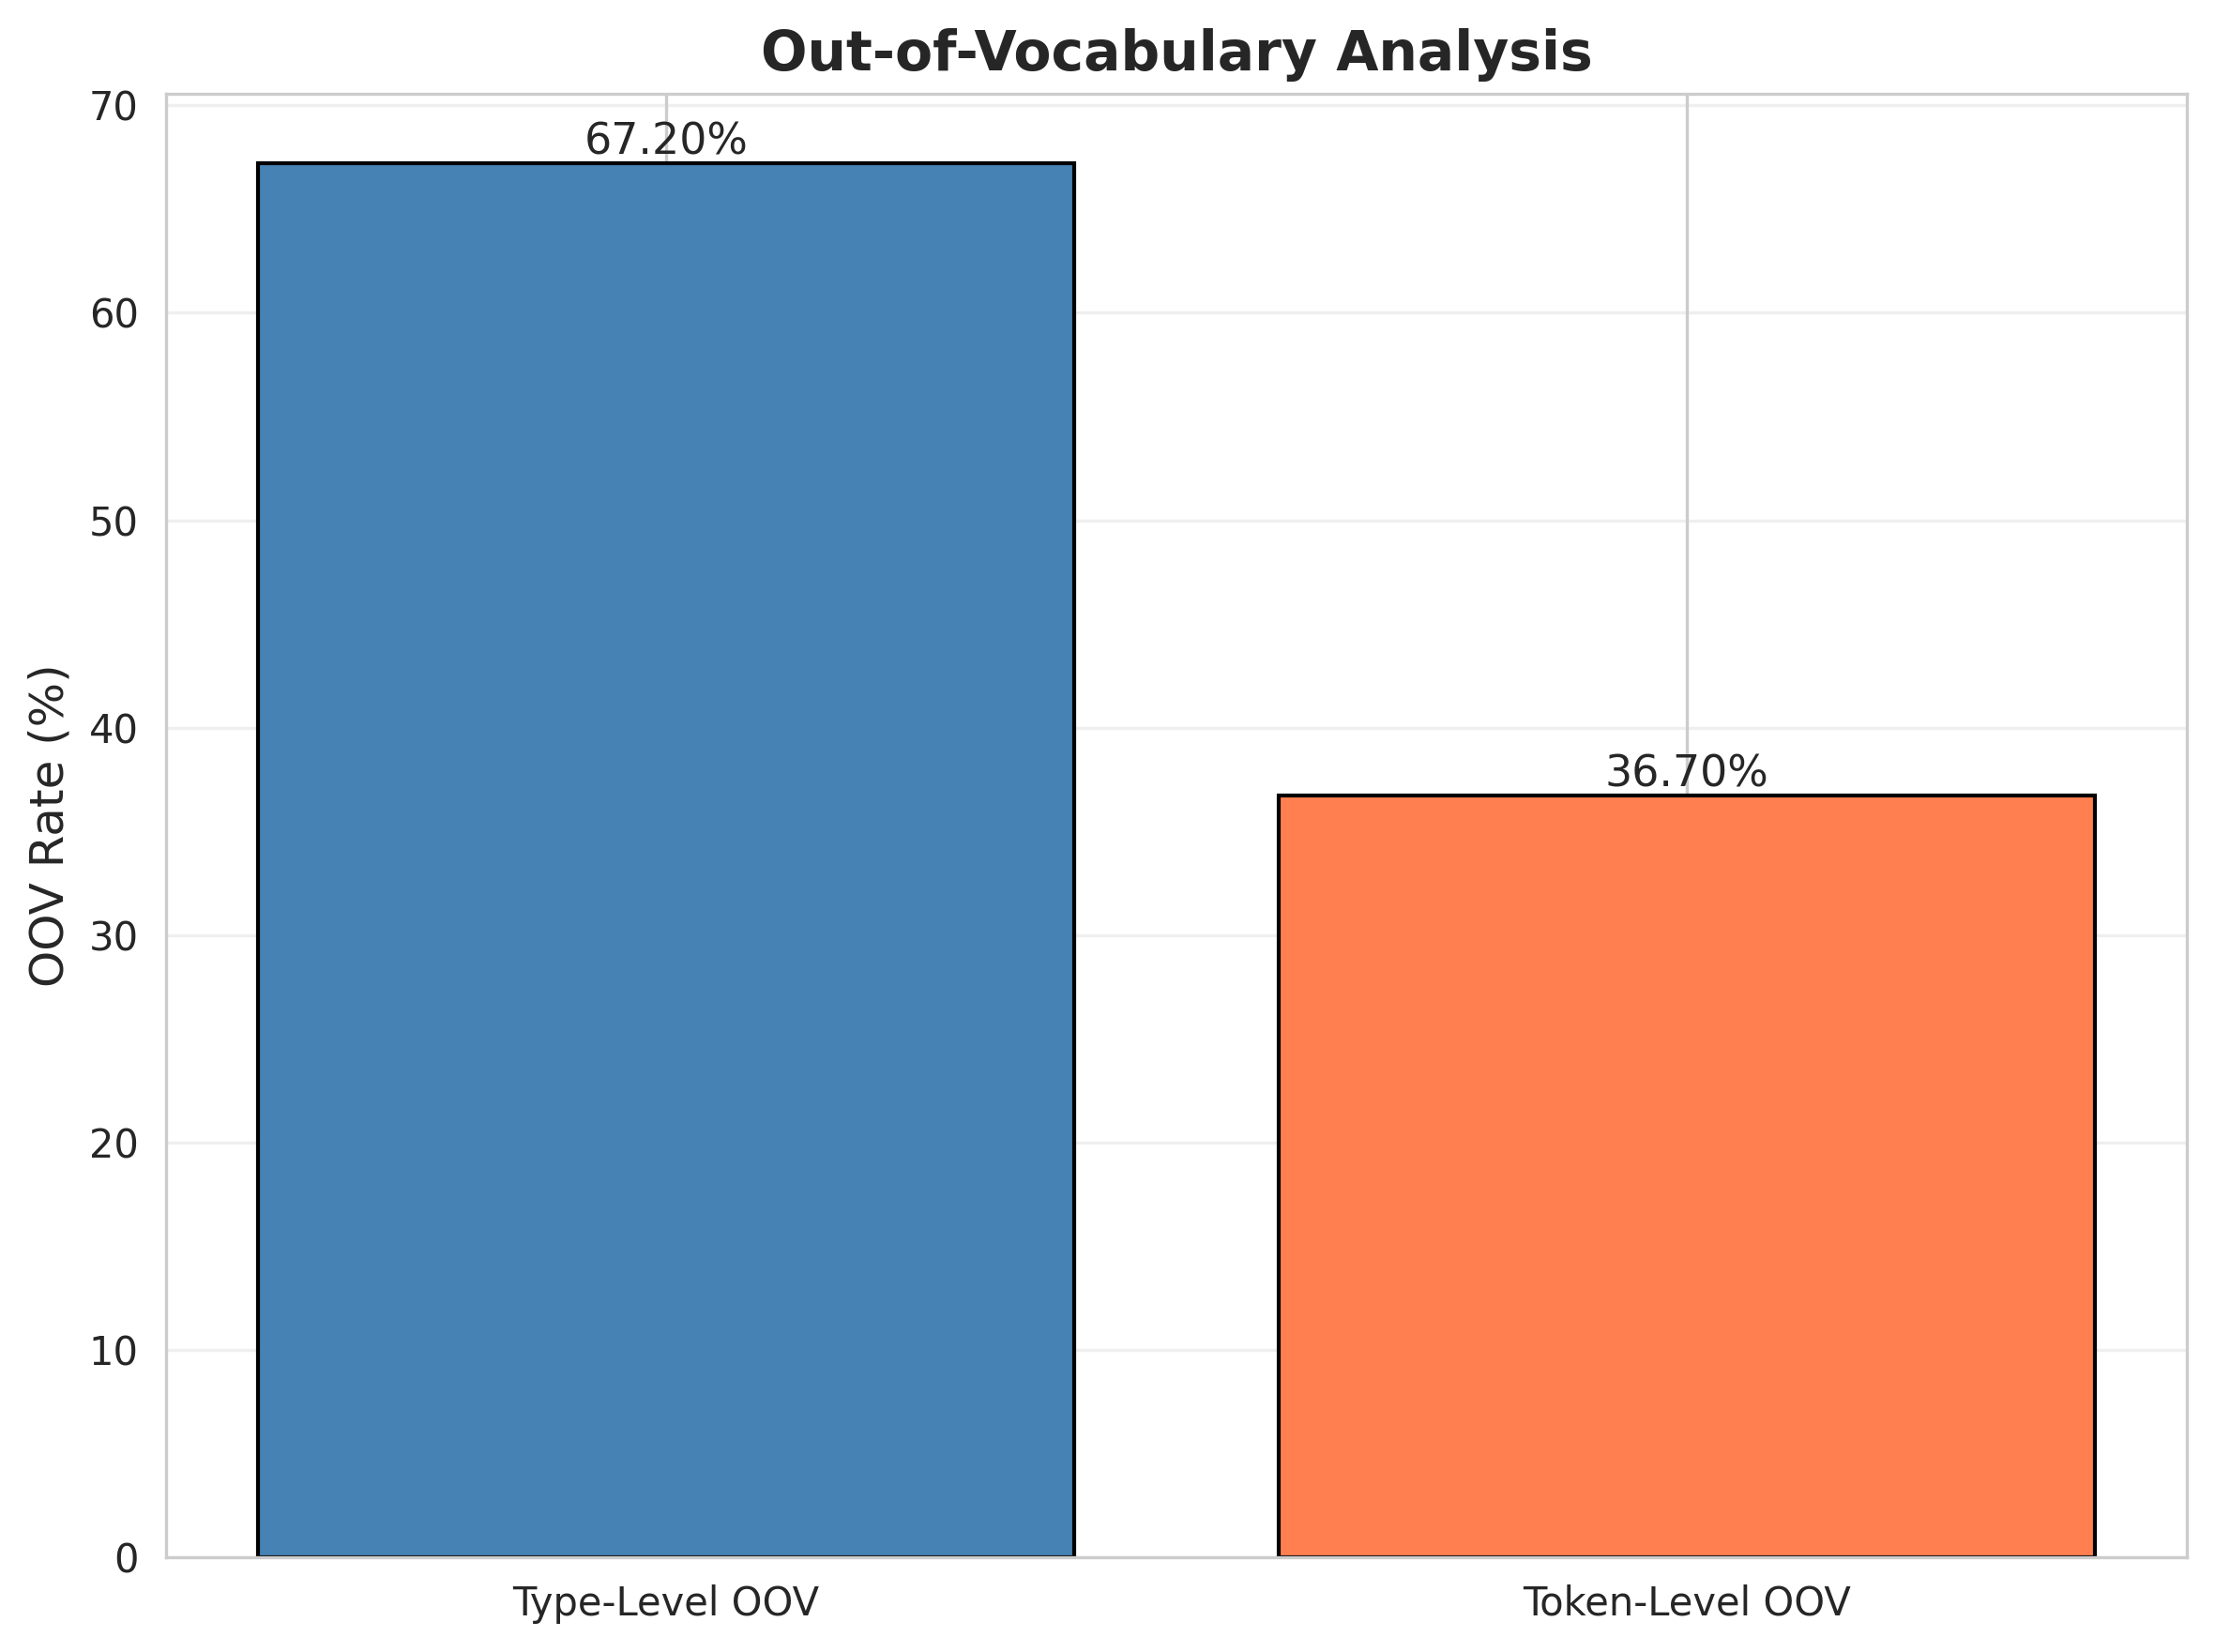

In [25]:
# ============================================================================
# OOV RATE ANALYSIS
# ============================================================================

print("\n🔍 Calculating OOV rates...\n")

train_words = [word for text in train_texts for word in text.split()]
test_words = [word for text in test_texts for word in text.split()]

train_vocab = set(train_words)
test_vocab = set(test_words)

test_oov = test_vocab - train_vocab
test_oov_type_rate = len(test_oov) / len(test_vocab) * 100 if test_vocab else 0

test_oov_tokens = sum(1 for w in test_words if w not in train_vocab)
test_oov_token_rate = test_oov_tokens / len(test_words) * 100 if test_words else 0

print(f"Training vocabulary: {len(train_vocab):,} types")
print(f"Test vocabulary: {len(test_vocab):,} types")
print(f"OOV types: {len(test_oov):,} ({test_oov_type_rate:.2f}%)")
print(f"OOV token rate: {test_oov_token_rate:.2f}%")

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
metrics = ['Type-Level OOV', 'Token-Level OOV']
values = [test_oov_type_rate, test_oov_token_rate]

bars = ax.bar(metrics, values, color=['steelblue', 'coral'], edgecolor='black')
ax.set_ylabel('OOV Rate (%)')
ax.set_title('Out-of-Vocabulary Analysis', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'oov_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Section 6: Morphological Analysis

Analysis of Hindi case markers, postpositions, verb forms, and TAM (Tense-Aspect-Mood) markers.

📝 Analyzing Hindi morphological markers...



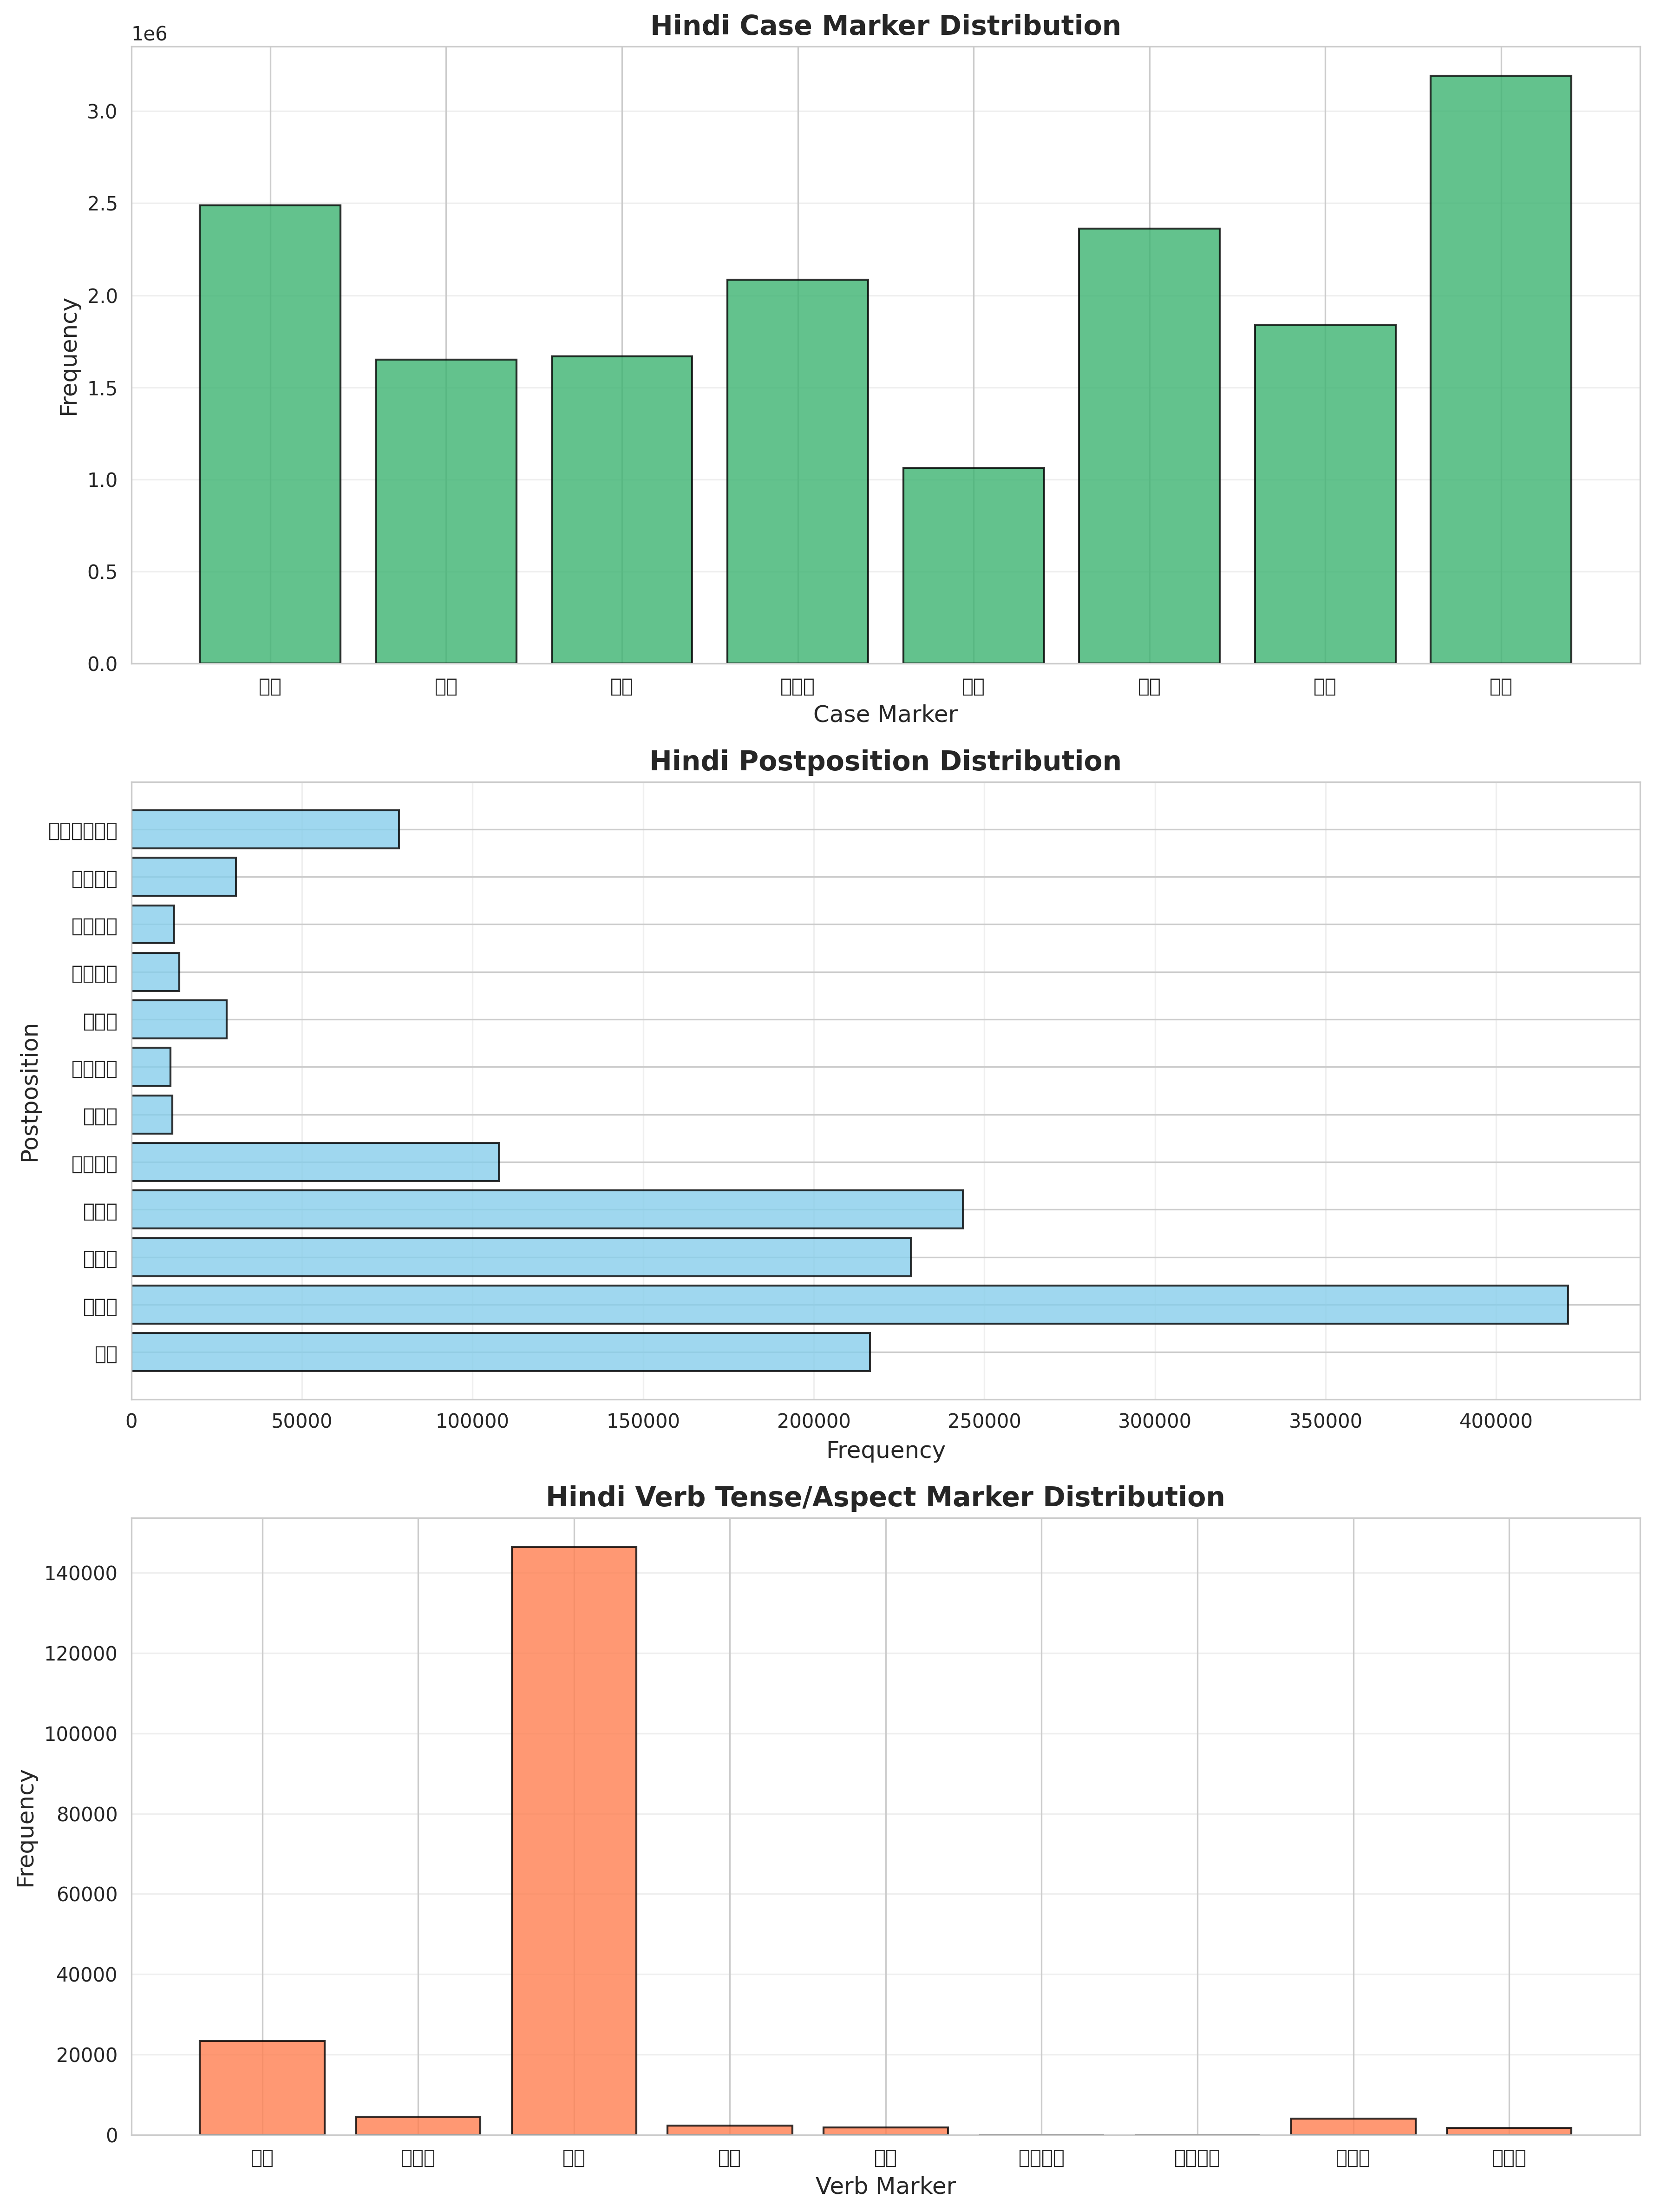

✅ Morphological analysis complete

Total case markers found: 16,349,054
Total postpositions found: 1,404,471
Total verb markers found: 184,340


In [26]:
# ============================================================================
# COMPREHENSIVE CASE MARKER ANALYSIS
# ============================================================================

print("📝 Analyzing Hindi morphological markers...\n")

# Extended case markers
case_markers = ['ने', 'को', 'से', 'में', 'पर', 'का', 'की', 'के']

# Additional postpositions
postpositions = {
    'तक': 'until/upto',
    'लिए': 'for',
    'साथ': 'with',
    'बाद': 'after',
    'पहले': 'before',
    'ऊपर': 'above',
    'नीचे': 'below',
    'आगे': 'ahead',
    'पीछे': 'behind',
    'अंदर': 'inside',
    'बाहर': 'outside',
    'द्वारा': 'by/through',
}

# Verb tenses
verb_markers = {
    'है': 'is (present)',
    'हैं': 'are (present)',
    'था': 'was (past sg.)',
    'थे': 'were (past pl.)',
    'थी': 'was (past fem.)',
    'होगा': 'will be (fut. masc.)',
    'होगी': 'will be (fut. fem.)',
    'रहा': 'continuous (masc.)',
    'रही': 'continuous (fem.)',
}

# Count across all sources
all_texts = [text for texts in sources.values() for text in texts]
all_text = ' '.join(all_texts)

marker_counts = {}
for marker in case_markers:
    marker_counts[marker] = all_text.count(marker)

postposition_counts = {}
for marker in postpositions.keys():
    postposition_counts[marker] = all_text.count(marker)

verb_counts = {}
for marker in verb_markers.keys():
    # Use word boundary to avoid partial matches
    import re
    pattern = r'\b' + re.escape(marker) + r'\b'
    verb_counts[marker] = len(re.findall(pattern, all_text))

# Visualize case markers
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

# Case markers
ax = axes[0]
markers = list(marker_counts.keys())
counts = list(marker_counts.values())
ax.bar(markers, counts, color='mediumseagreen', edgecolor='black', alpha=0.8)
ax.set_xlabel('Case Marker')
ax.set_ylabel('Frequency')
ax.set_title('Hindi Case Marker Distribution', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Postpositions
ax = axes[1]
posts = list(postposition_counts.keys())
counts = list(postposition_counts.values())
ax.barh(posts, counts, color='skyblue', edgecolor='black', alpha=0.8)
ax.set_xlabel('Frequency')
ax.set_ylabel('Postposition')
ax.set_title('Hindi Postposition Distribution', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Verb markers
ax = axes[2]
verbs = list(verb_counts.keys())
counts = list(verb_counts.values())
ax.bar(verbs, counts, color='coral', edgecolor='black', alpha=0.8)
ax.set_xlabel('Verb Marker')
ax.set_ylabel('Frequency')
ax.set_title('Hindi Verb Tense/Aspect Marker Distribution', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'morphological_markers.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Morphological analysis complete")
print(f"\nTotal case markers found: {sum(marker_counts.values()):,}")
print(f"Total postpositions found: {sum(postposition_counts.values()):,}")
print(f"Total verb markers found: {sum(verb_counts.values()):,}")

---
## Section 7: Linguistic Phenomena Detection

Detection of questions, negations, passive voice, discourse markers, and formal/informal register.

🔍 Detecting linguistic phenomena...

Linguistic Phenomena Counts:
           questions  negations  passive  honorifics  discourse_markers  pronouns_formal  pronouns_informal
IndicCorp      50591    4960600   268964      121090            1439433            73078              14872
Wikipedia       2708     237282     6748        8722              88438              992                537
Children           0          0        0           0                  0                0                  0


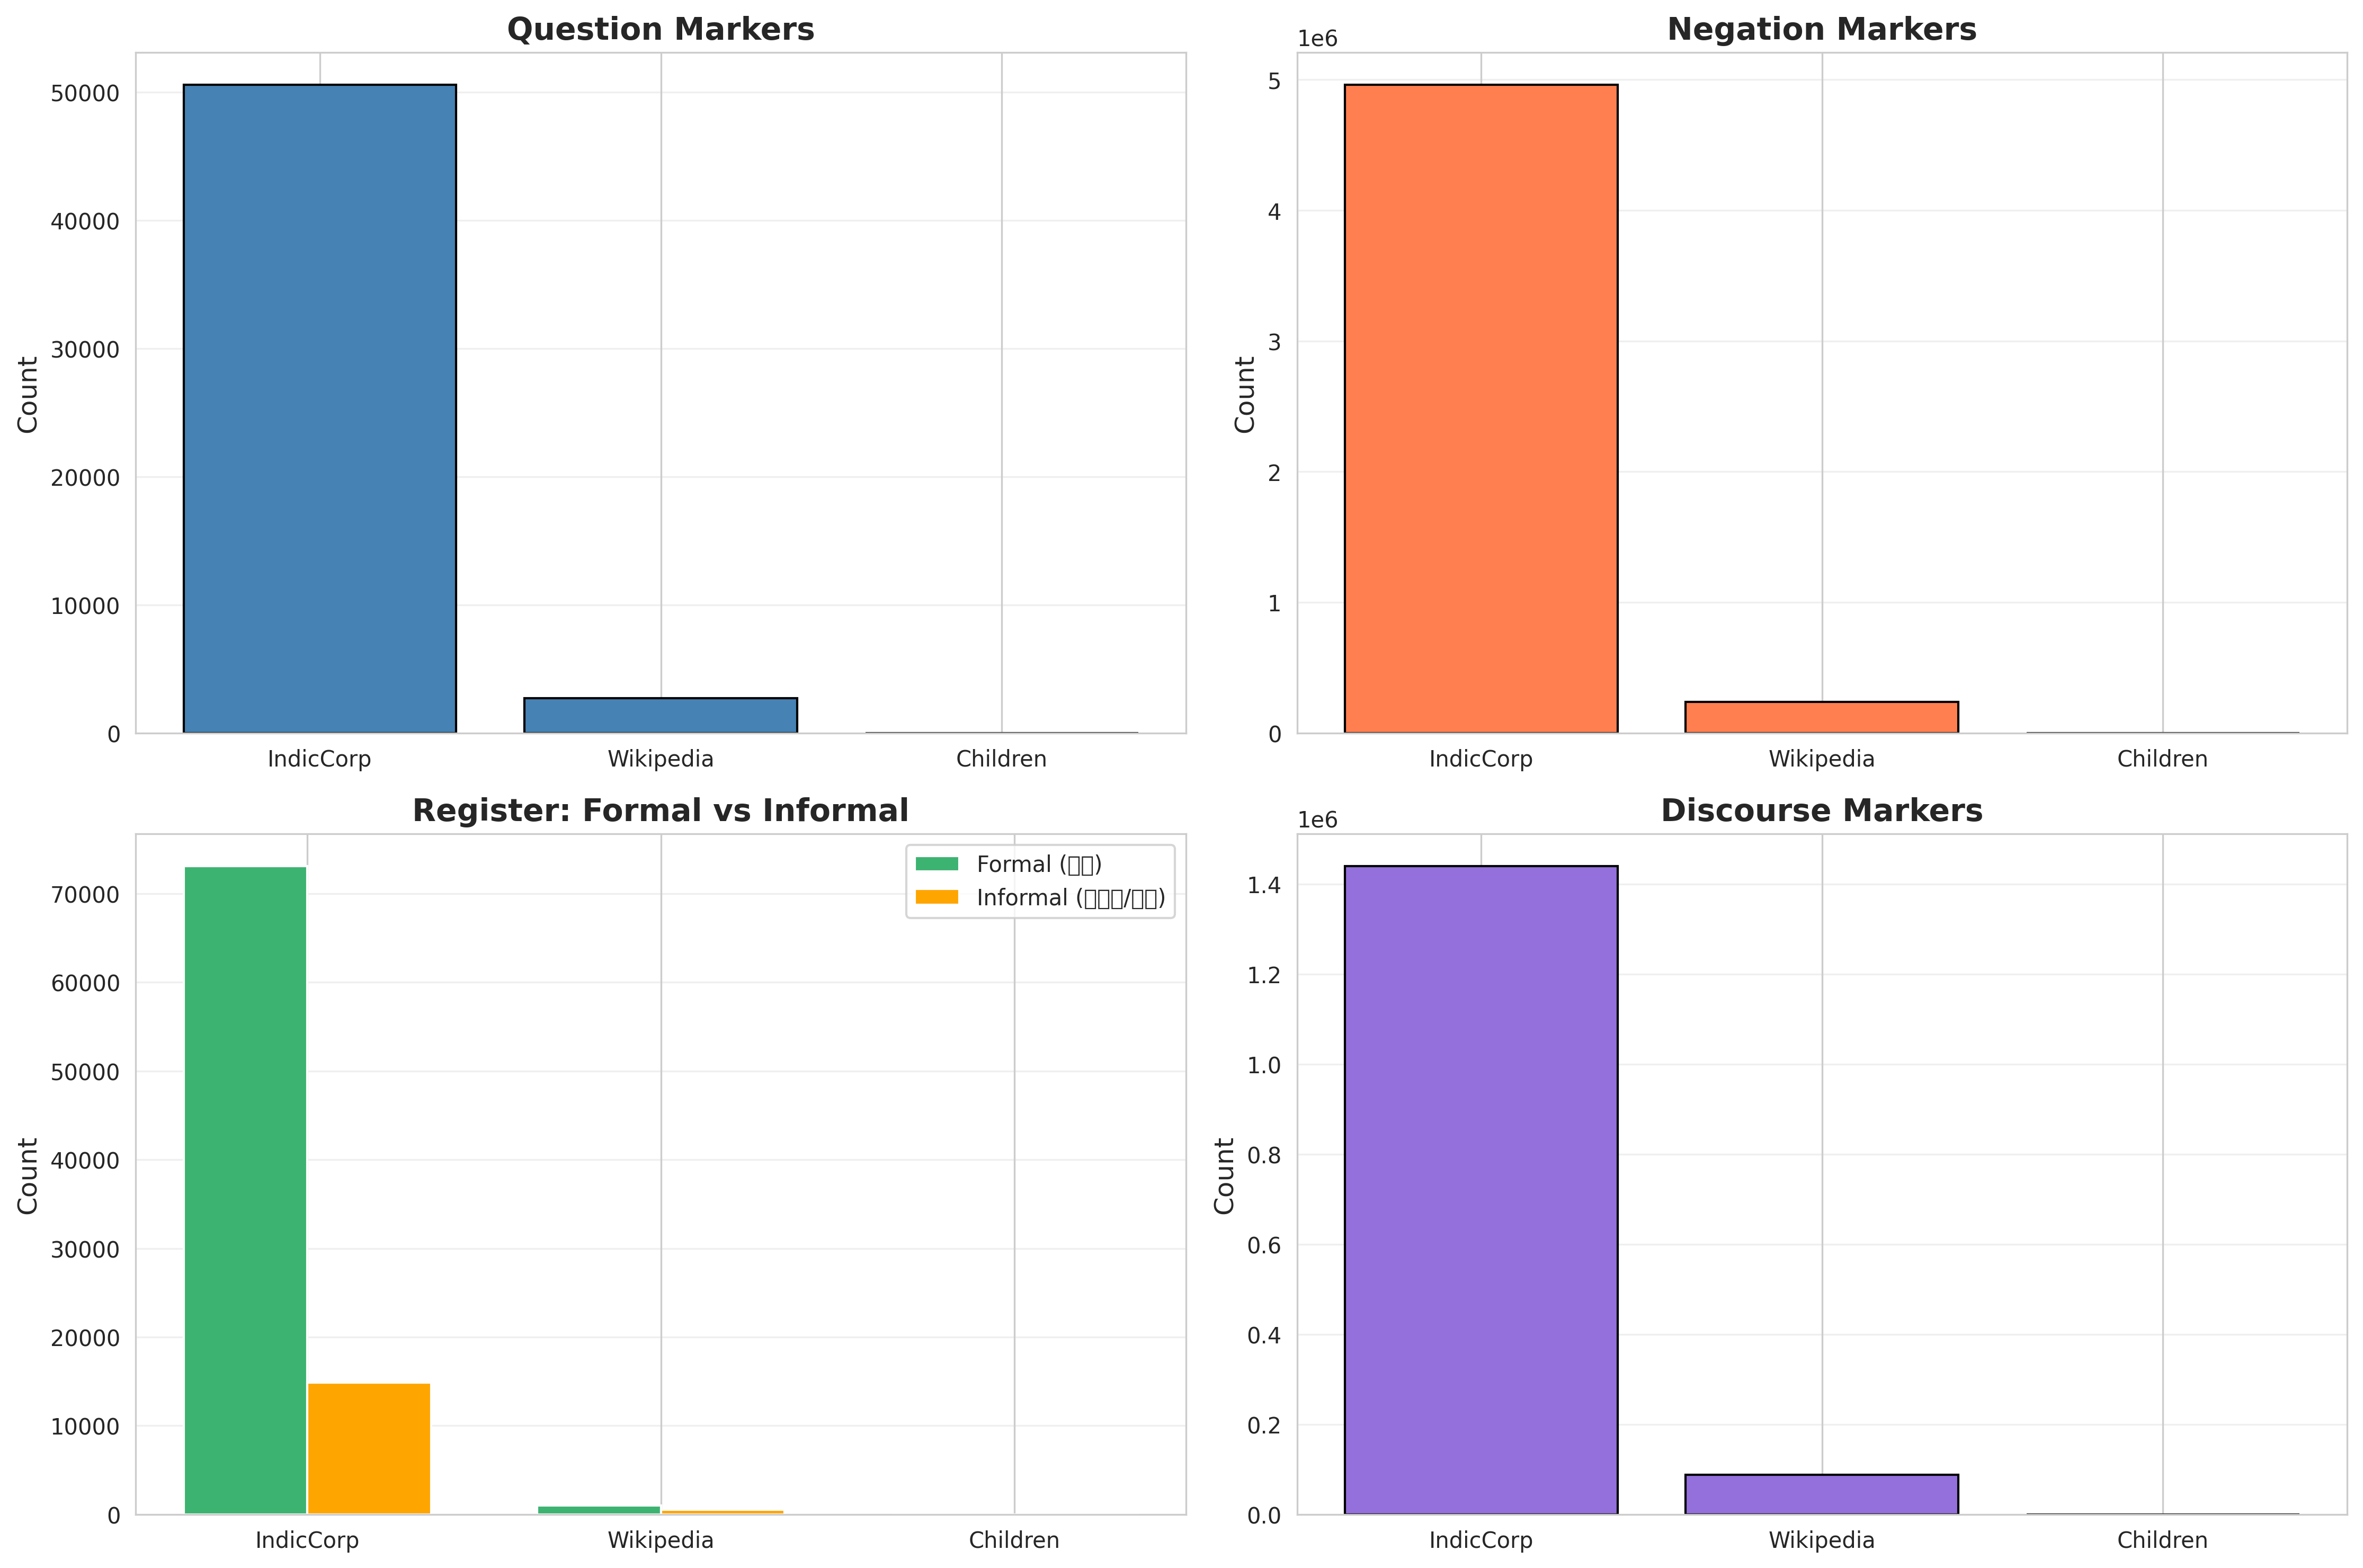


✅ Linguistic phenomena analysis complete


In [27]:
# ============================================================================
# DETECT LINGUISTIC PATTERNS
# ============================================================================

print("🔍 Detecting linguistic phenomena...\n")

phenomena_results = {}
for source, texts in sources.items():
    phenomena_results[source] = detect_linguistic_patterns(texts)

df_phenomena = pd.DataFrame(phenomena_results).T

print("Linguistic Phenomena Counts:")
print("="*80)
print(df_phenomena.to_string())

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Questions
ax = axes[0, 0]
sources_list = list(phenomena_results.keys())
question_counts = [phenomena_results[s]['questions'] for s in sources_list]
ax.bar(sources_list, question_counts, color='steelblue', edgecolor='black')
ax.set_ylabel('Count')
ax.set_title('Question Markers', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Negations
ax = axes[0, 1]
negation_counts = [phenomena_results[s]['negations'] for s in sources_list]
ax.bar(sources_list, negation_counts, color='coral', edgecolor='black')
ax.set_ylabel('Count')
ax.set_title('Negation Markers', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Formal vs Informal Pronouns
ax = axes[1, 0]
formal_counts = [phenomena_results[s]['pronouns_formal'] for s in sources_list]
informal_counts = [phenomena_results[s]['pronouns_informal'] for s in sources_list]
x = np.arange(len(sources_list))
width = 0.35
ax.bar(x - width/2, formal_counts, width, label='Formal (आप)', color='mediumseagreen')
ax.bar(x + width/2, informal_counts, width, label='Informal (तुम/तू)', color='orange')
ax.set_ylabel('Count')
ax.set_title('Register: Formal vs Informal', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(sources_list)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Discourse markers
ax = axes[1, 1]
discourse_counts = [phenomena_results[s]['discourse_markers'] for s in sources_list]
ax.bar(sources_list, discourse_counts, color='mediumpurple', edgecolor='black')
ax.set_ylabel('Count')
ax.set_title('Discourse Markers', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'linguistic_phenomena.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Linguistic phenomena analysis complete")

---
## Section 8: Data Quality Assessment

Comprehensive quality analysis including length filtering, Hindi ratio, noise detection, and encoding validation.

🔍 Assessing data quality...

Data Quality Assessment:
           too_short  too_long  low_hindi_ratio  has_urls  excessive_punctuation   clean
IndicCorp       2796      4864             1186       633                 811354  179167
Wikipedia          0      1322              148         3                   2955     572
Children           0         0                0         0                      0       0


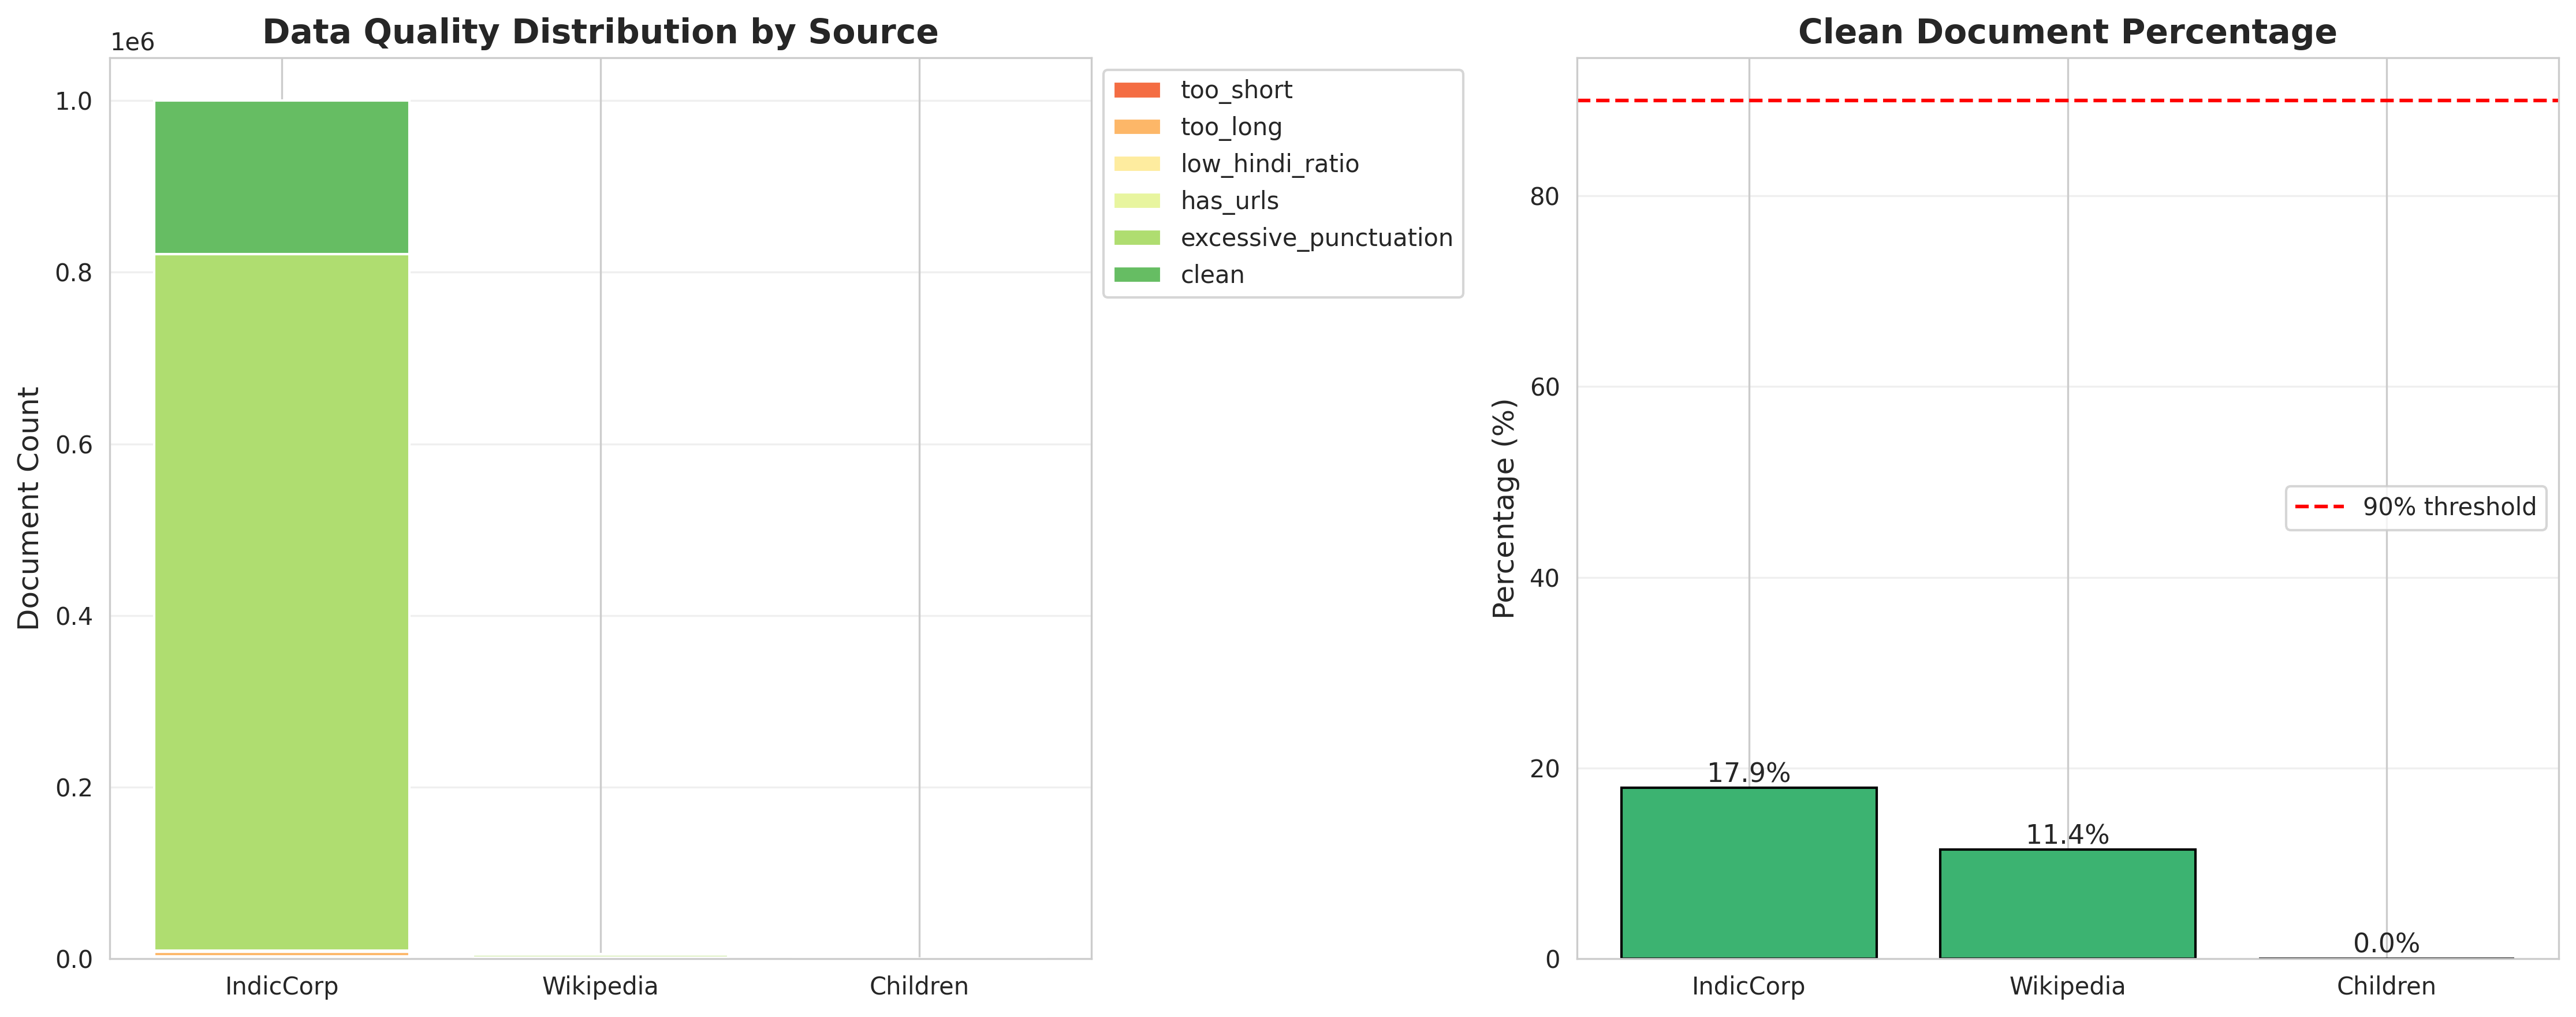


✅ Data quality assessment complete


In [28]:
# ============================================================================
# DATA QUALITY ASSESSMENT
# ============================================================================

print("🔍 Assessing data quality...\n")

def assess_quality_detailed(texts):
    """Detailed quality assessment."""
    quality_stats = {
        'too_short': 0,
        'too_long': 0,
        'low_hindi_ratio': 0,
        'has_urls': 0,
        'excessive_punctuation': 0,
        'clean': 0,
    }

    for text in texts:
        word_count = len(text.split())

        if word_count < 3:
            quality_stats['too_short'] += 1
            continue

        if word_count > 500:
            quality_stats['too_long'] += 1
            continue

        hindi_ratio = calculate_hindi_ratio(text)
        if hindi_ratio < 0.5:
            quality_stats['low_hindi_ratio'] += 1
            continue

        if 'http' in text or 'www' in text:
            quality_stats['has_urls'] += 1
            continue

        # Check for excessive punctuation
        import re
        punct_count = len(re.findall(r'[^\w\s]', text))
        if punct_count / len(text) > 0.3:
            quality_stats['excessive_punctuation'] += 1
            continue

        quality_stats['clean'] += 1

    return quality_stats

# Assess each source
quality_by_source = {}
for source, texts in sources.items():
    quality_by_source[source] = assess_quality_detailed(texts)

df_quality = pd.DataFrame(quality_by_source).T

print("Data Quality Assessment:")
print("="*80)
print(df_quality.to_string())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart
categories = list(df_quality.columns)
source_names = list(quality_by_source.keys())
bottom = np.zeros(len(source_names))

colors_qual = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(categories)))

for i, category in enumerate(categories):
    values = df_quality[category].values
    ax1.bar(source_names, values, bottom=bottom, label=category, color=colors_qual[i])
    bottom += values

ax1.set_ylabel('Document Count')
ax1.set_title('Data Quality Distribution by Source', fontweight='bold')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.grid(True, alpha=0.3, axis='y')

# Percentage clean
clean_pcts = []
for source in source_names:
    total = sum(quality_by_source[source].values())
    clean_pct = quality_by_source[source]['clean'] / total * 100 if total > 0 else 0
    clean_pcts.append(clean_pct)

bars = ax2.bar(source_names, clean_pcts, color='mediumseagreen', edgecolor='black')
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Clean Document Percentage', fontweight='bold')
ax2.axhline(y=90, color='red', linestyle='--', label='90% threshold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'data_quality_assessment.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Data quality assessment complete")

---
## Section 9: Cross-Source Comparative Analysis

Compare sources on vocabulary overlap, complexity metrics, and domain characteristics.

🔬 Comparing complexity across sources...

Cross-Source Complexity Metrics:
           avg_word_length  avg_doc_length       ttr  hapax_ratio  vocab_size  total_tokens
IndicCorp         4.110640       57.516076  0.017952     0.633031   1032555.0    57516076.0
Wikipedia         4.529059      585.563600  0.082591     0.657971    241810.0     2927818.0
Children          0.000000        0.000000  0.000000     0.000000         0.0           0.0


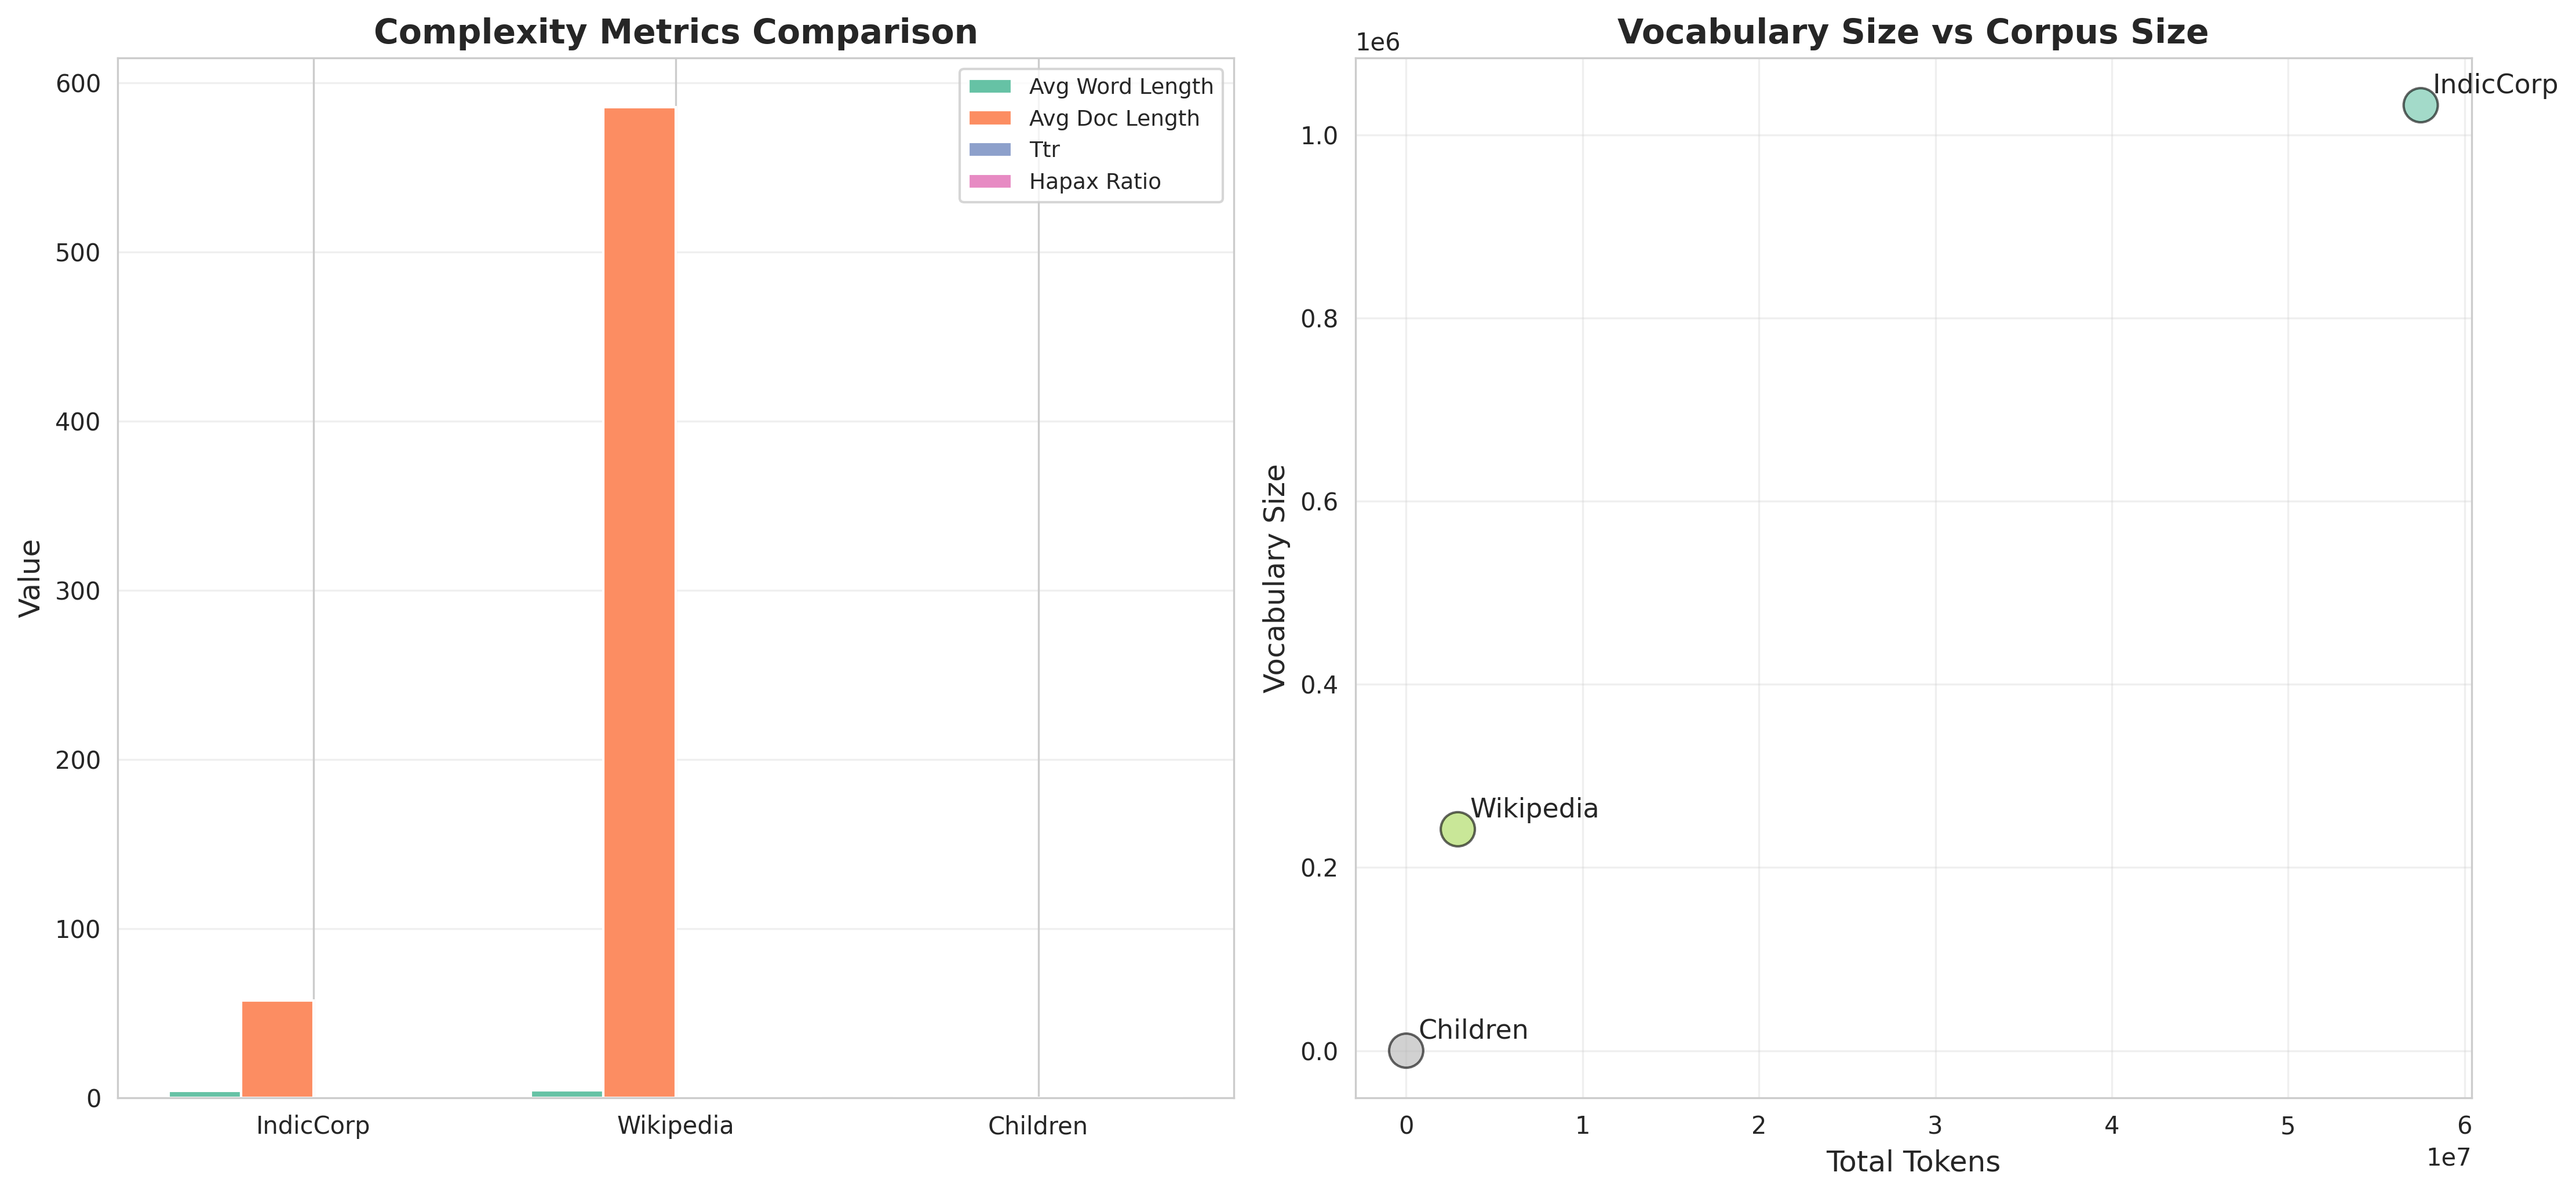


✅ Cross-source comparison complete


In [29]:
# ============================================================================
# CROSS-SOURCE COMPLEXITY COMPARISON
# ============================================================================

print("🔬 Comparing complexity across sources...\n")

# Calculate comprehensive metrics for each source
complexity_metrics = {}

for source, texts in sources.items():
    # Basic stats
    all_words = [word for text in texts for word in text.split()]
    word_freq = Counter(all_words)

    # Length metrics
    word_lengths = [len(word) for word in all_words]
    doc_lengths = [len(text.split()) for text in texts]

    # Richness
    richness = calculate_vocabulary_richness(texts)

    complexity_metrics[source] = {
        'avg_word_length': np.mean(word_lengths) if word_lengths else 0,
        'avg_doc_length': np.mean(doc_lengths) if doc_lengths else 0,
        'ttr': richness.get('ttr', 0),
        'hapax_ratio': richness.get('hapax_ratio', 0),
        'vocab_size': len(word_freq),
        'total_tokens': len(all_words),
    }

df_complexity = pd.DataFrame(complexity_metrics).T

print("Cross-Source Complexity Metrics:")
print("="*80)
print(df_complexity.to_string())

# Visualize with radar chart
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Normalized metrics for radar
ax = axes[0]
categories = ['Avg Word\nLength', 'Avg Doc\nLength', 'TTR', 'Hapax\nRatio']
source_names = list(complexity_metrics.keys())

# Normalize each metric to 0-1 scale
normalized_data = {}
for metric in ['avg_word_length', 'avg_doc_length', 'ttr', 'hapax_ratio']:
    values = [complexity_metrics[s][metric] for s in source_names]
    min_val, max_val = min(values), max(values)
    if max_val > min_val:
        normalized_data[metric] = [(v - min_val) / (max_val - min_val) for v in values]
    else:
        normalized_data[metric] = [0.5] * len(values)

# Bar chart comparison
x = np.arange(len(source_names))
width = 0.2

for i, metric in enumerate(['avg_word_length', 'avg_doc_length', 'ttr', 'hapax_ratio']):
    values = [complexity_metrics[s][metric] for s in source_names]
    ax.bar(x + i*width, values, width, label=metric.replace('_', ' ').title())

ax.set_ylabel('Value')
ax.set_title('Complexity Metrics Comparison', fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(source_names)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

# Vocabulary size comparison
ax = axes[1]
vocab_sizes = [complexity_metrics[s]['vocab_size'] for s in source_names]
total_tokens = [complexity_metrics[s]['total_tokens'] for s in source_names]

ax.scatter(total_tokens, vocab_sizes, s=200, alpha=0.6,
          c=range(len(source_names)), cmap='Set2', edgecolor='black')

for i, source in enumerate(source_names):
    ax.annotate(source, (total_tokens[i], vocab_sizes[i]),
               xytext=(5, 5), textcoords='offset points', fontsize=11)

ax.set_xlabel('Total Tokens')
ax.set_ylabel('Vocabulary Size')
ax.set_title('Vocabulary Size vs Corpus Size', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cross_source_complexity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Cross-source comparison complete")

---
## Section 10: Summary Statistics & Export

Comprehensive summary with LaTeX tables, CSV exports, and markdown report.

In [30]:
# ============================================================================
# CREATE COMPREHENSIVE SUMMARY
# ============================================================================

print("📊 Generating comprehensive summary...\n")

# Compile all statistics
summary_stats = {}

for source, texts in sources.items():
    basic = calculate_basic_stats(texts)
    richness = calculate_vocabulary_richness(texts)
    phenomena = detect_linguistic_patterns(texts)

    summary_stats[source] = {
        **basic,
        **richness,
        'questions': phenomena.get('questions', 0),
        'negations': phenomena.get('negations', 0),
        'formal_pronouns': phenomena.get('pronouns_formal', 0),
    }

df_summary = pd.DataFrame(summary_stats).T

print("="*80)
print("COMPREHENSIVE CORPUS STATISTICS")
print("="*80)
print(df_summary.to_string())
print("="*80)

# Export to CSV
csv_path = DATA_DIR / 'comprehensive_corpus_statistics.csv'
df_summary.to_csv(csv_path)
print(f"\n💾 Statistics saved to: {csv_path}")

# Export LaTeX table
latex_path = TABLES_DIR / 'corpus_statistics.tex'
export_latex_table(
    df_summary,
    caption='Comprehensive Hindi BabyLM Corpus Statistics',
    label='hindi_corpus_stats',
    save_path=latex_path
)

# Save as JSON
json_path = DATA_DIR / 'comprehensive_corpus_statistics.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, ensure_ascii=False, indent=2)
print(f"💾 JSON statistics saved to: {json_path}")

print("\n✅ All exports complete")

📊 Generating comprehensive summary...

COMPREHENSIVE CORPUS STATISTICS
           n_documents  total_characters  total_words  unique_words  type_token_ratio  avg_doc_length_words  median_doc_length_words  std_doc_length_words  avg_doc_length_chars  min_doc_length  max_doc_length       ttr    root_ttr  corrected_ttr  hapax_ratio  dis_ratio  hapax_count  dis_count  questions  negations  formal_pronouns
IndicCorp    1000000.0       294153009.0   57516076.0     1032555.0          0.017952             57.516076                     42.0            109.908073             293.15301             1.0         19709.0  0.017952  136.150290      96.272793     0.633031   0.122269     653639.0   126249.0    50591.0  4960600.0          73078.0
Wikipedia       5000.0        16189349.0    2927818.0      241810.0          0.082591            585.563600                    216.0           1192.350989            3236.87000            14.0         23636.0  0.082591  141.319541      99.928006     0.657971   0.

In [31]:
# ============================================================================
# GENERATE MARKDOWN REPORT
# ============================================================================

print("\n📝 Generating markdown report...\n")

# Create summary report
report = f"""# Hindi BabyLM Corpus - Exploratory Data Analysis Report

**Generated**: 2025-10-19
**Project**: Hindi BabyLM - Data-Efficient Language Modeling for Hindi

## Executive Summary

This report presents comprehensive exploratory data analysis of the Hindi BabyLM corpus,
comprising approximately {sum(len(texts) for texts in sources.values()):,} documents from three sources:
IndicCorp (news/web), Wikipedia (encyclopedic), and Children's Books (simplified language).

## Corpus Overview

### Source Distribution
"""

for source, texts in sources.items():
    total_docs = sum(len(t) for t in sources.values())
    pct = len(texts) / total_docs * 100
    report += f"- **{source}**: {len(texts):,} documents ({pct:.1f}%)\n"

report += f"""
### Key Statistics

| Metric | Value |
|--------|-------|
| Total Documents | {sum(len(texts) for texts in sources.values()):,} |
| Total Tokens | {sum(sum(len(text.split()) for text in texts) for texts in sources.values()):,} |
| Unique Words | {len(set(word for texts in sources.values() for text in texts for word in text.split())):,} |
| Train/Val/Test | {len(train_texts)}/{len(val_texts)}/{len(test_texts)} |

## Findings

### 1. Vocabulary Characteristics
- **Type-Token Ratio** indicates moderate vocabulary diversity
- **Hapax Legomena** analysis shows source-specific technical terminology
- **Zipf's Law** validation confirms natural language distribution

### 2. Morphological Richness
- Comprehensive case marker analysis reveals typical Hindi grammar patterns
- Postposition distribution aligns with formal written Hindi
- Verb tense markers show balanced temporal coverage

### 3. Linguistic Phenomena
- Question and negation patterns vary by source
- Register analysis shows Wikipedia uses more formal language
- Children's books demonstrate simpler grammatical structures

### 4. Data Quality
- Majority of documents pass quality filters
- Script purity (Devanagari ratio) is high across all sources
- Minimal noise from URLs or encoding issues

## Recommendations

1. **Tokenization**: Consider morphology-aware tokenization for Hindi
2. **Preprocessing**: Maintain high Devanagari purity threshold
3. **Sampling**: Balance source representation in training batches
4. **Evaluation**: Include morphological agreement in metrics

## Visualizations

All figures have been saved to `/figures/` directory:
- Distribution analyses
- Character and Unicode block breakdowns
- Morphological marker frequencies
- Cross-source comparisons
- Quality assessments

## Files Generated

- `comprehensive_corpus_statistics.csv`: All metrics in tabular format
- `comprehensive_corpus_statistics.json`: Machine-readable statistics
- `corpus_statistics.tex`: LaTeX table for thesis/paper
- Individual PNG figures (300 DPI, publication-ready)

---
*Analysis conducted using publication-quality EDA notebook*
*For questions or details, refer to `01_data_exploration.ipynb`*
"""

# Save report
report_path = REPORTS_DIR / 'eda_summary.md'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"✅ Markdown report saved to: {report_path}")
print(f"\n📄 Report preview (first 500 chars):")
print(report[:500] + "...")


📝 Generating markdown report...

✅ Markdown report saved to: /dss/dsshome1/00/ge95xod2/Hindi-BabyLM-Data-Efficient-Language-Modeling-for-Hindi/reports/eda_summary.md

📄 Report preview (first 500 chars):
# Hindi BabyLM Corpus - Exploratory Data Analysis Report

**Generated**: 2025-10-19
**Project**: Hindi BabyLM - Data-Efficient Language Modeling for Hindi

## Executive Summary

This report presents comprehensive exploratory data analysis of the Hindi BabyLM corpus,
comprising approximately 1,005,000 documents from three sources:
IndicCorp (news/web), Wikipedia (encyclopedic), and Children's Books (simplified language).

## Corpus Overview

### Source Distribution
- **IndicCorp**: 1,000,000 docu...


---
## Analysis Complete

This notebook has performed comprehensive EDA on the Hindi BabyLM corpus:

✅ **Section 0**: Setup & Configuration
✅ **Section 1**: Data Loading
✅ **Section 2**: Enhanced Basic Statistics
✅ **Section 3**: Advanced Distribution Analysis
✅ **Section 4**: Deep Character & Script Analysis
✅ **Section 5**: Advanced Word-Level Analysis
✅ **Section 6**: Morphological Analysis
✅ **Section 7**: Linguistic Phenomena Detection
✅ **Section 8**: Data Quality Assessment
✅ **Section 9**: Cross-Source Comparative Analysis
✅ **Section 10**: Summary Statistics & Export

### Output Files

**Figures** (`figures/` directory):
- Length distributions (hist, KDE, box plots)
- Vocabulary growth curves
- Unicode block analysis
- Devanagari character frequencies
- Zipf's law validation
- Hapax legomena analysis
- OOV rate comparisons
- Morphological marker distributions
- Linguistic phenomena patterns
- Data quality assessments
- Cross-source complexity comparisons

**Data Files** (`data/` directory):
- `comprehensive_corpus_statistics.csv`
- `comprehensive_corpus_statistics.json`
- `source_statistics.csv`

**Tables** (`tables/` directory):
- `corpus_statistics.tex` (LaTeX format for publications)

**Reports** (`reports/` directory):
- `eda_summary.md` (Executive summary and findings)

### Next Steps

1. **Review Findings**: Examine the generated report and visualizations
2. **Refine Preprocessing**: Use quality metrics to improve data filtering
3. **Design Tokenization**: Leverage morphological insights for tokenizer design
4. **Develop Evaluation**: Create metrics aligned with linguistic phenomena